In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime

# plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.colors
import circlify
import seaborn as sns

# ML
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

sns.set()
tqdm.pandas() # enable progress bar for pandas apply

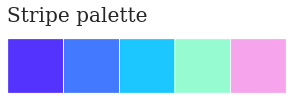

In [2]:
# Graphics setup

FONTSIZE_TITLE = 15
STRIPE_COLORS = ['#5433FF', '#4379FF', '#1CC6FF', '#97FBD1', '#F6A4EC']
FONTFAMILY_TITLE = 'bagnard'
FONTFAMILY = 'monospace'
plt.rcParams["font.family"] = "monospace"
backgrouond_color = '#fafafa'

any_stripe_colors = lambda k=1: np.random.choice(STRIPE_COLORS, size=k, replace=False)
cmap_stripe = matplotlib.colors.LinearSegmentedColormap.from_list("", STRIPE_COLORS[-3:])
cmap_stripe_mono = lambda: matplotlib.colors.LinearSegmentedColormap.from_list("", ['#fafafa', *any_stripe_colors(1)])
                                                                              
sns.palplot(STRIPE_COLORS)
plt.title("Stripe palette ",loc='left',fontfamily='serif',fontsize=20,y=1.2)
plt.show()

# Goals

Given the transaction data on some merchants between Jan 2033 and December 2034, we would like to
1. **Cluster merchants** into several distinct groups to distinguish their transactional behavior.
* Do they tend to process small transactions frequently, or do they have more rare larger ones? (a special business model)?
* Are they selling consistenly throught the year, or seasonally (i.e. tourist businesses)?
* Do they profit more on weekends and after work hours? (bar, restaurants, entertainment venues)
* Are they a growing business (transactions increasing either in amount or frequency) or declining?
* Are they a loyal customer or just trying out Stripe?
* Are they a completely new customer? How new is considered "new"? Little to no transaction history available

We want to find the optimal number of clusters and assign each merchant to one.

2. **Predict Churn** (probability of not using Stripe) for each merchant.
First, we need to define Churn. Clearly, it means that a merchant is no longer actively using Stripe, but "actively" is a relative term. Did they have no transactions in the last week, month, quarter? Some business, like touristic ones, may have longer breaks between transactions. It does not mean they have abandonded Stripe as a payment processing platform, but could indicate a special business model.
Having no transactions in the next period is different from merchant to merchant. For those that used to have trsansactions every week, a month is along break and can be considered churn. For a seasonal business, a break can be half a year.

# What is the point of this?

Grouping merchants allows us to customize our services and pricing for each group, depending on their needs.

* Customized pricing startegy, such as discounts for high-volume merchants; or a transaction fee % varied by the total amount of transaction
* Offering helpful services, such as automated accounting
* Mailing automation: automatically send offers to customers that are very likely to churn in the next period

Estimating churn helps us calculate Customer Lifetime Value (how mcuh revenue we expect to generate from a certain customer)

### Load data

Are there any missing values?

Are there any impossible values? (i.e. timestamp outside expected range)

In [3]:
data_raw = pd.read_csv('../data/takehome_ds_written.csv', index_col=[0])
data_raw['time']= pd.to_datetime(data_raw['time'])
data_raw = data_raw.sort_values(by=['merchant', 'time'], ascending=True)
data_raw['amount_usd'] = data_raw.amount_usd_in_cents / 100
data = data_raw.copy()

data.head()

merchant                time  amount_usd_in_cents  amount_usd
438309   0002b63b92 2033-05-16 20:07:57                 3379       33.79
1123973  0002d07bba 2034-10-11 17:02:26                 5549       55.49
835994   0002d07bba 2034-10-17 17:57:32                37830      378.30
891756   0002d07bba 2034-11-13 15:42:55                43842      438.42
874951   0002d07bba 2034-12-15 09:56:19                 2057       20.57

In [4]:
# check for negative values
data.amount_usd_in_cents.min()

201

In [5]:
# check for null values
data.isnull().sum()

merchant               0
time                   0
amount_usd_in_cents    0
amount_usd             0
dtype: int64

In [6]:
# make sure date range is correct
print(f'{data.time.min()} - {data.time.max()}')

2033-01-01 09:38:32 - 2034-12-31 07:59:40


We have no information about the type of transactions, only the amount processed and a time stamp. Hence, we can only distinguish merchants by the volatility of transactions and their amount, as well as by temporal features.

# 0. Data Exploration

We want to explore features that could be relevant for clustering and predicting churn. For example:
* time between transactions - how often does a merchant process a transaction, on average? Does this time vary a lot (consistency)
* transaction amount - do they sell expensive or cheap products? A mix?
* Do they sell primarily on weekends or after work hours?
* is the number of transactions increasing or decreasing in frequency, as time goes by?
* is the total period (monthly/weekly) transaction amount increasing or decreasing with time? 
* How long were they customers? Days since first transaction
* How much time has passed since their last transaction

In [7]:
def transactions_overview(df):
    n_transactions = df.shape[0]
    n_merchants = df.merchant.nunique()
    n_avg_trx = df.groupby('merchant').count().time.mean()
    avg_trx_amount = df.amount_usd.mean()
    
    print(f'Total number of transactions in the set: {n_transactions:,}')
    print(f'Total number of merchants in the set: {n_merchants:,}')
    print(f'Average #transactions by a merchant: {round(n_avg_trx)}')
    print(f'Average transaction amount: ${round(avg_trx_amount,2)}')
    
transactions_overview(data)

Total number of transactions in the set: 1,513,719
Total number of merchants in the set: 14,351
Average #transactions by a merchant: 105
Average transaction amount: $154.85


In [8]:
# add amount in dollars
data['amount_usd'] = data['amount_usd_in_cents'] / 100
data.drop('amount_usd_in_cents', axis=1, inplace=True)

In [9]:
# Add Time between Transactions

def calculate_time_between_trx(data):
    """Calculate days passed since last transaction for the same merchant."""
    time_shift = (data.time - data.time.shift(1))
    data['min_since_last_trx'] = time_shift.dt.total_seconds() / 60
    data['days_since_last_trx'] = time_shift.dt.days
    data['months_since_last_trx'] = data['days_since_last_trx'] / 30
    return data.fillna(0)

data = data.groupby('merchant').progress_apply(lambda merchant_trx: calculate_time_between_trx(merchant_trx))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14351/14351 [00:16<00:00, 891.73it/s]


In [10]:
pct_trx_within_day = data[data.days_since_last_trx < 1].shape[0] / data.shape[0]
print(f'{round(pct_trx_within_day*100, 2)}% of transactions are processed within a day of the previous one')

pct_trx_within_hour = data[data.min_since_last_trx < 60].shape[0] / data.shape[0]
print(f'{round(pct_trx_within_hour*100, 2)}% of transactions are processed within an hour of the previous one')

pct_trx_within_month = data[data.months_since_last_trx < 1].shape[0] / data.shape[0]
print(f'{round(pct_trx_within_month*100, 2)}% of transactions are processed within a month of the previous one')

82.52% of transactions are processed within a day of the previous one
42.67% of transactions are processed within an hour of the previous one
98.88% of transactions are processed within a month of the previous one


The overwhelming majority of transactions are processed within a day of the previous one. We do not expect most merchants to have along break between transactions.

99th- percentilke of transaction amount is 1687.1258000000125


Text(0.5, 0, 'Months Passed Since Previous Transaction')

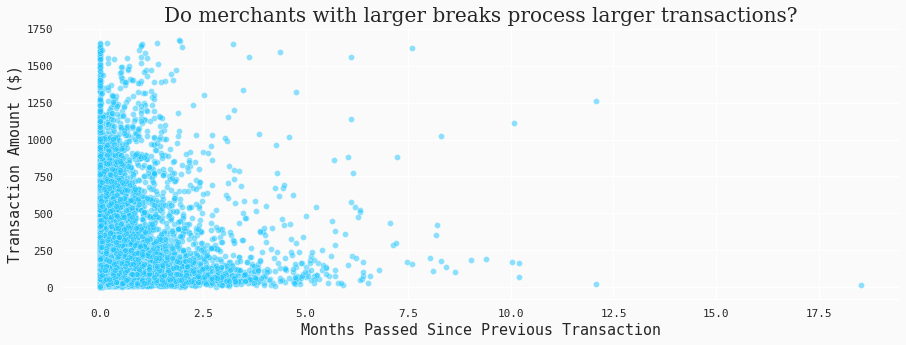

In [11]:
# trsancation amount is heavily skewed and has lots of outliers
# let's clip values for better visibility
amount_usd_clip = np.percentile(data.amount_usd,99)
print(f'99th- percentilke of transaction amount is {amount_usd_clip}')

fig, ax = plt.subplots(figsize=(15,5))
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

for pos in ['top', 'left', 'right']:
    ax.spines[pos].set_visible(False)
sns.scatterplot(data=data.query('amount_usd <= @amount_usd_clip').groupby('merchant').agg({'months_since_last_trx': np.mean, 'amount_usd':np.mean}),
                x='months_since_last_trx', y='amount_usd', alpha=0.5, color=any_stripe_colors(1), ax=ax)

plt.title('Do merchants with larger breaks process larger transactions?', fontsize=20, fontfamily='serif')
plt.ylabel('Transaction Amount ($)', fontsize=15)
plt.xlabel('Months Passed Since Previous Transaction', fontsize=15)

Unfortunately there is no clear relationship here

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 48.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


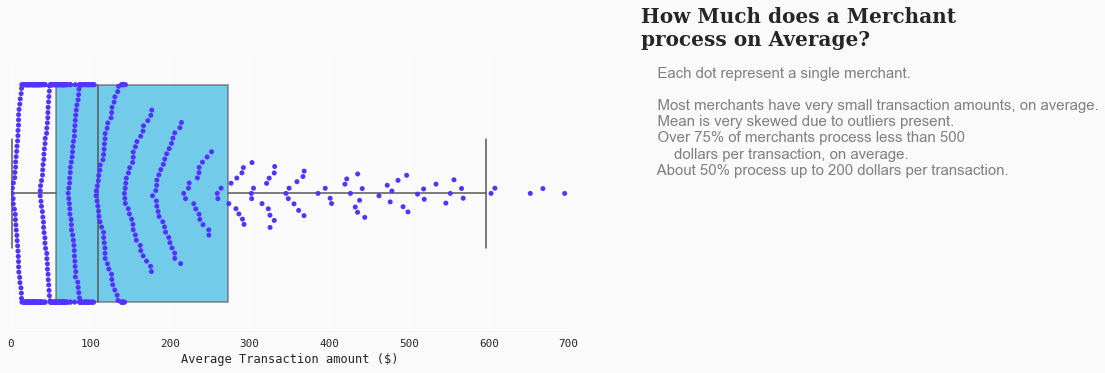

In [12]:
def transactions_boxplot(data, agg_func, title, xlabel, annot_text, text_ypos=1.0):
    colors = any_stripe_colors(2)
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    background_color = "#fafafa"
    fig.patch.set_facecolor(background_color) # figure background color
    ax.set_facecolor(background_color)

    sns.boxplot(x=data.groupby('merchant').amount_usd.apply(lambda x: agg_func(x)),
                showfliers=False, color=colors[0], boxprops=dict(alpha=.7), ax=ax)
    sns.swarmplot(x=data.sample(1000).groupby('merchant').amount_usd.apply(lambda x: agg_func(x)), color=colors[1], ax=ax)

    for pos in ['top', 'left', 'right']:
        ax.spines[pos].set_visible(False)
    
    fig.text(1, text_ypos, title, fontweight='bold', fontfamily='serif', fontsize=20,ha='left', va='bottom')
    fig.text(1, text_ypos, annot_text,
             fontfamily='sans', fontsize=15,ha='left', va='top', color='grey')

    ax.set_xlim(0,700)
    ax.set_xlabel(xlabel)
    
annot_text_mean = """
    Each dot represent a single merchant.

    Most merchants have very small transaction amounts, on average.
    Mean is very skewed due to outliers present.
    Over 75% of merchants process less than 500
        dollars per transaction, on average.
    About 50% process up to 200 dollars per transaction.
    """
title_mean = 'How Much does a Merchant\nprocess on Average?'
xlabel_mean = 'Average Transaction amount ($)'

transactions_boxplot(data, np.mean, title_mean, xlabel_mean, annot_text_mean, text_ypos=0.9)

99th- percentilke of transaction amount is 1687.1258000000125


Text(0, 0.5, 'Transaction Amount, deviation from the mean')

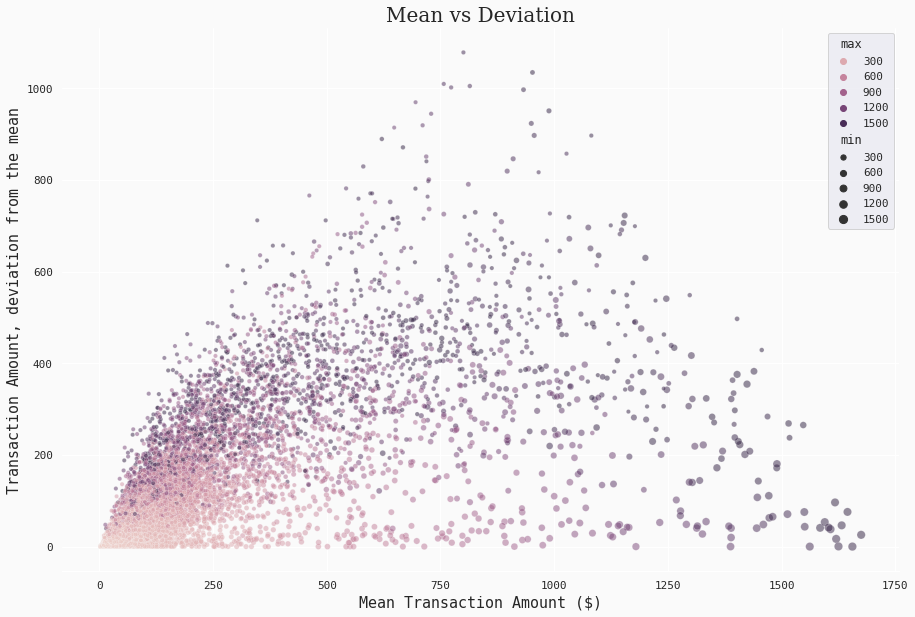

In [13]:
# transaction amount is heavily skewed and has lots of outliers
# let's clip values for better visibility
amount_usd_clip = np.percentile(data.amount_usd,99)
print(f'99th- percentilke of transaction amount is {amount_usd_clip}')

fig, ax = plt.subplots(figsize=(15,10))
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

for pos in ['top', 'left', 'right']:
    ax.spines[pos].set_visible(False)
data_plot = data.query('amount_usd <= @amount_usd_clip').groupby('merchant').agg({'amount_usd': [np.mean, np.std, min, max]})
data_plot.columns = ['mean', 'std', 'min', 'max']
sns.scatterplot(data=data_plot,
                x='mean', y='std', size='min', hue='max', alpha=0.5, ax=ax)

plt.title('Mean vs Deviation', fontsize=20, fontfamily='serif')
plt.xlabel('Mean Transaction Amount ($)', fontsize=15)
plt.ylabel('Transaction Amount, deviation from the mean', fontsize=15)

Again, no clear relationship, although we do notice that there is a bucnh of merchants with high average transaction amount and quite low deviation. These get large sums consistently, which could indicate a "big business"

69.66% of merchants were active at least one month


Text(0, 0.5, 'number of transactions')

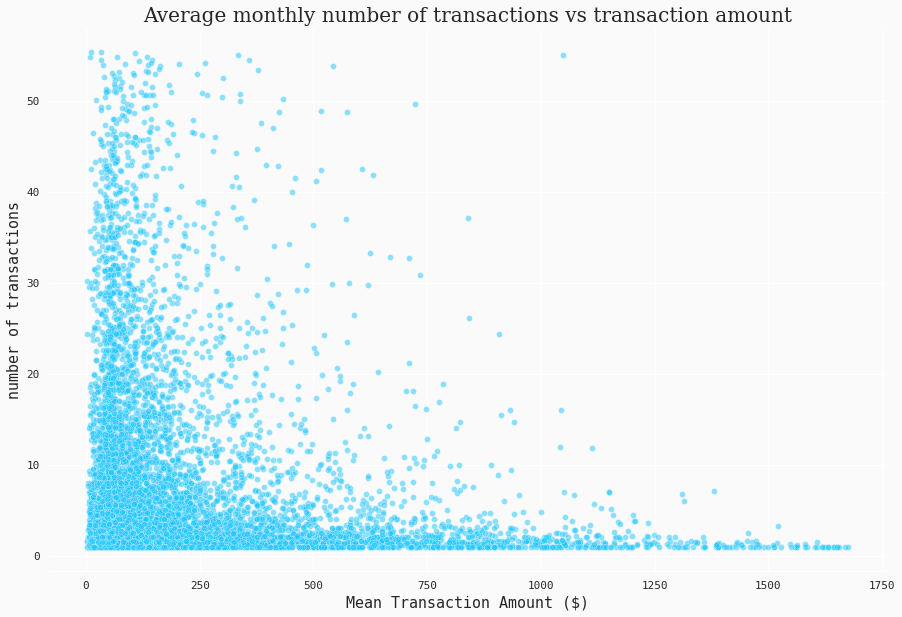

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

for pos in ['top', 'left', 'right']:
    ax.spines[pos].set_visible(False)
first_last_trx_time = data.groupby('merchant').time.agg([min,max])
merchants_at_least_one_month = first_last_trx_time[(first_last_trx_time['max'] - first_last_trx_time['min']).dt.days > 30].index
print(f'{round(len(merchants_at_least_one_month)/data.merchant.nunique()*100,2)}% of merchants were active at least one month')
data_plot = data.query('(merchant in @merchants_at_least_one_month) and (amount_usd <= @amount_usd_clip)')
data_plot = data_plot.groupby(['merchant', data.time.dt.to_period('M')]).agg({'amount_usd': [len, np.mean]}).groupby(level=0).mean()
data_plot.columns = ['n_trx', 'mean_trx']
clip_trx_count = np.percentile(data_plot.n_trx, 95)
data_plot = data_plot[data_plot.n_trx <= clip_trx_count]
sns.scatterplot(data=data_plot,
                x='mean_trx', y='n_trx', alpha=0.5, ax=ax, color=any_stripe_colors(1))

plt.title('Average monthly number of transactions vs transaction amount', fontsize=20, fontfamily='serif')
plt.xlabel('Mean Transaction Amount ($)', fontsize=15)
plt.ylabel('number of transactions', fontsize=15)

## Kurtosis and Skew

Additional features to describe the distribution of transaction amount by a merchant.
Since we are doing clustering and churn classification on a merchnat level, we are going to loove time series data for each merchant. That is why we want to generate many features to describe the transction time series, such as it's mean, trend, is it skewed, ...

We could also generate a lot of the  features, such as min and max amount monthly/weekly etc. Then we would need to do a feature selection to limit the number of features and remove those that just add noise to predictions. But now due to lack of time we are. focusing on a few promising ones.

Skew - measure of the (lack of) symmetry

Kurtosis - measure of how heavy the tails are compared to normal distribution

Text(0.5, 1.0, 'Skew of transactions (by merchant)')

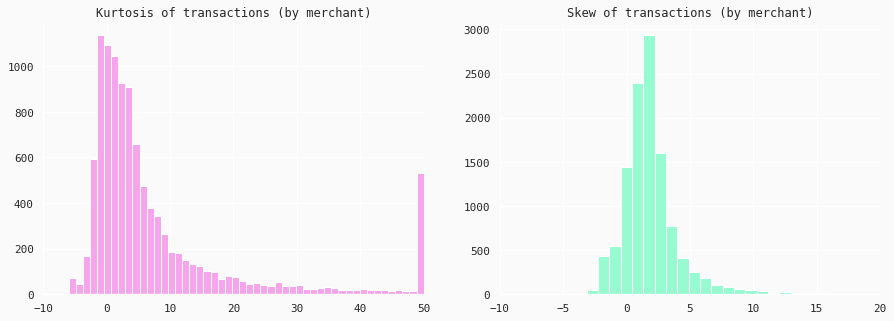

In [15]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
colors = any_stripe_colors(2)
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
axs[0].set_facecolor(background_color)
axs[1].set_facecolor(background_color)
for pos in ['top', 'left', 'right']:
    axs[0].spines[pos].set_visible(False)
    axs[1].spines[pos].set_visible(False)

kurtosis_trx_amount = data.groupby(data.merchant).amount_usd.apply(lambda m: m.kurtosis())
#kurtosis_trx_amount = kurtosis_trx_amount.clip(-50,50)
kurtosis_trx_amount.name = 'kurtosis_trx_amount'
kurtosis_trx_amount.hist(ax=axs[0], bins=50, color=colors[0])
axs[0].set_xlim(-10,50)
axs[0].set_title('Kurtosis of transactions (by merchant)')

skew_trx_amount = data.groupby(data.merchant).amount_usd.apply(lambda m: m.skew())
skew_trx_amount = skew_trx_amount
skew_trx_amount.name = 'skew_trx_amount'
skew_trx_amount.hist(ax=axs[1], bins=50, color=colors[1])
axs[1].set_xlim(-10,20)
axs[1].set_title('Skew of transactions (by merchant)')

What does it mean?

# Trend

We are using spearman correlation that uses ranking and not absolute values to describe a linear trend in the transaction amount and transaction count
For this, we will compute a correlation value between actual values and an ordered index i.e. [0,1,2,3,...]

In [16]:
spearman_corr_monthly = data.groupby(['merchant', data.time.dt.to_period('M')]).mean().amount_usd\
    .groupby(level=0).apply(lambda m: m.reset_index().drop('time', axis=1).reset_index()\
                            .corr(method="spearman").iloc[0].iloc[1]).fillna(0)
spearman_corr_monthly.name = 'spearman_corr_monthly'

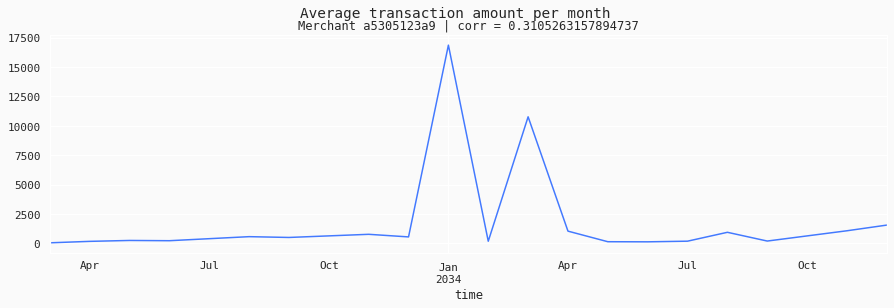

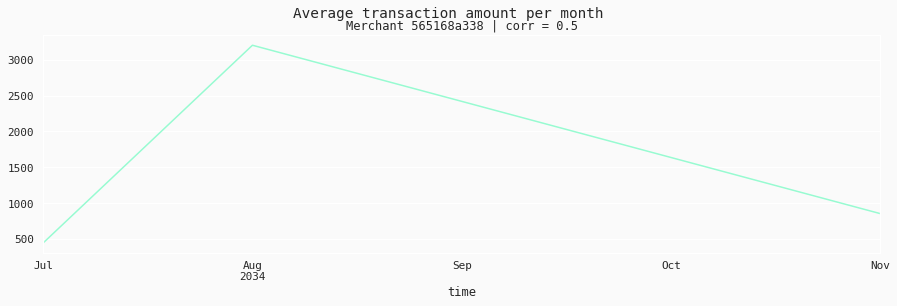

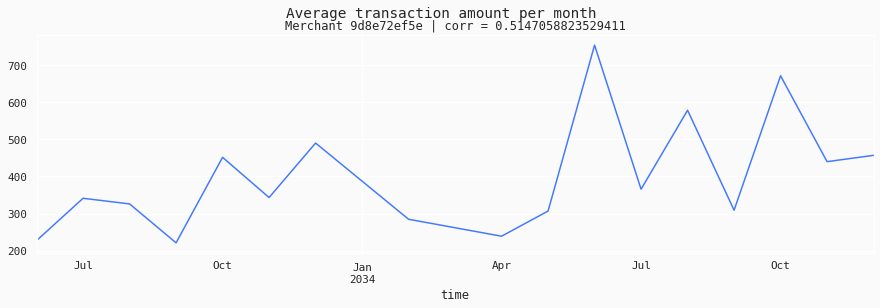

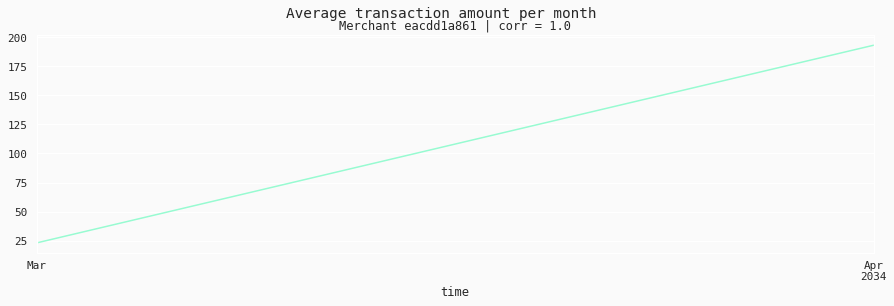

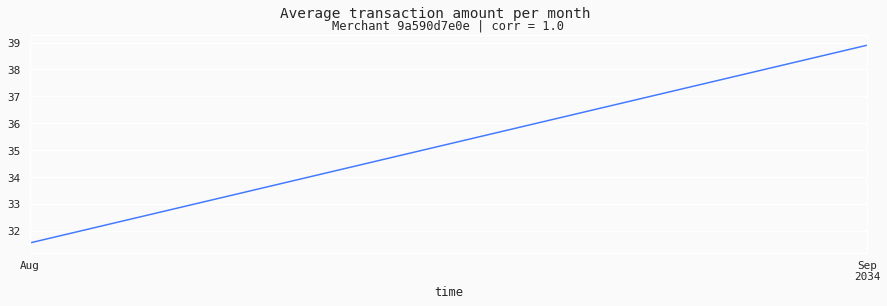

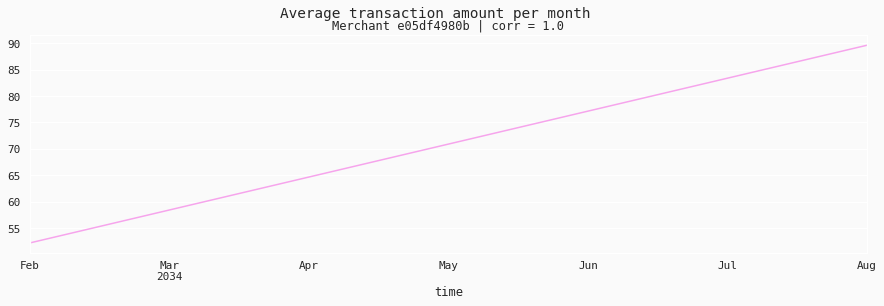

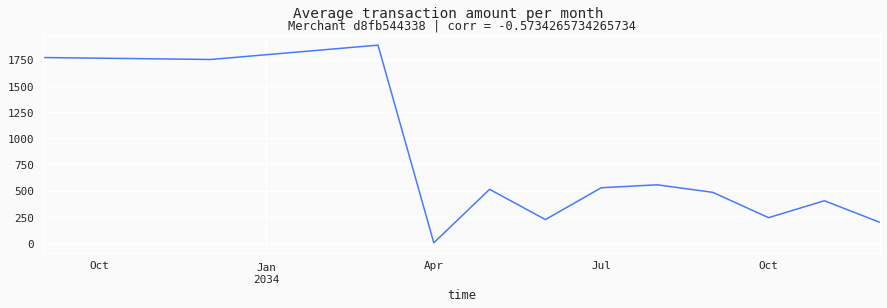

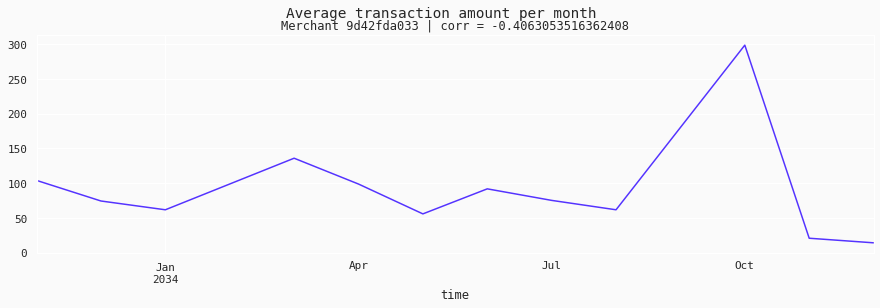

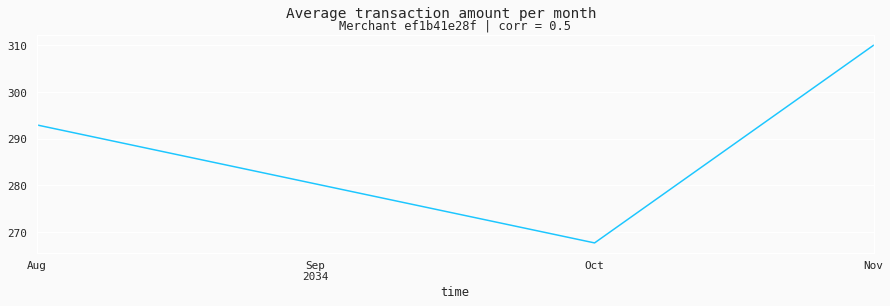

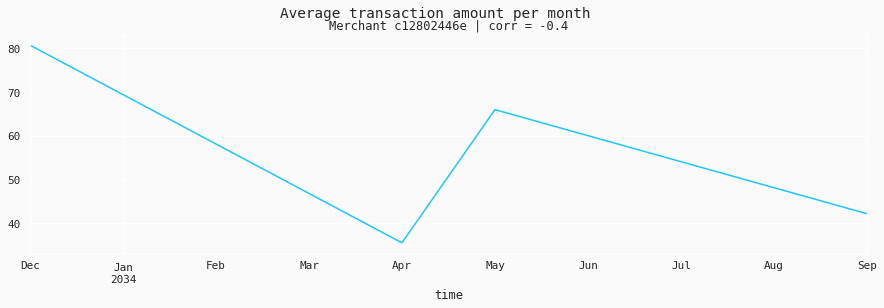

In [17]:
for MERCHANT_ID in spearman_corr_monthly[spearman_corr_monthly!=0].sample(10).index:

    fig, ax = plt.subplots(1,1,figsize=(15,4))
    background_color = "#fafafa"
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)
    
    data[data.merchant==MERCHANT_ID].groupby([data.time.dt.to_period('M')]).mean()\
        .amount_usd.plot(color=any_stripe_colors(1))
    plt.suptitle('Average transaction amount per month')
    plt.title(f'Merchant {MERCHANT_ID} | corr = {spearman_corr_monthly.loc[MERCHANT_ID]}')

It's far from perfect and does place more importance on latest values, but it will do for the sake of time.

## Weekend vs Workdays and After Work Hours effect

Text(0.5, 0.98, 'How do average transactions look like,\ngiven weekday and hour?')

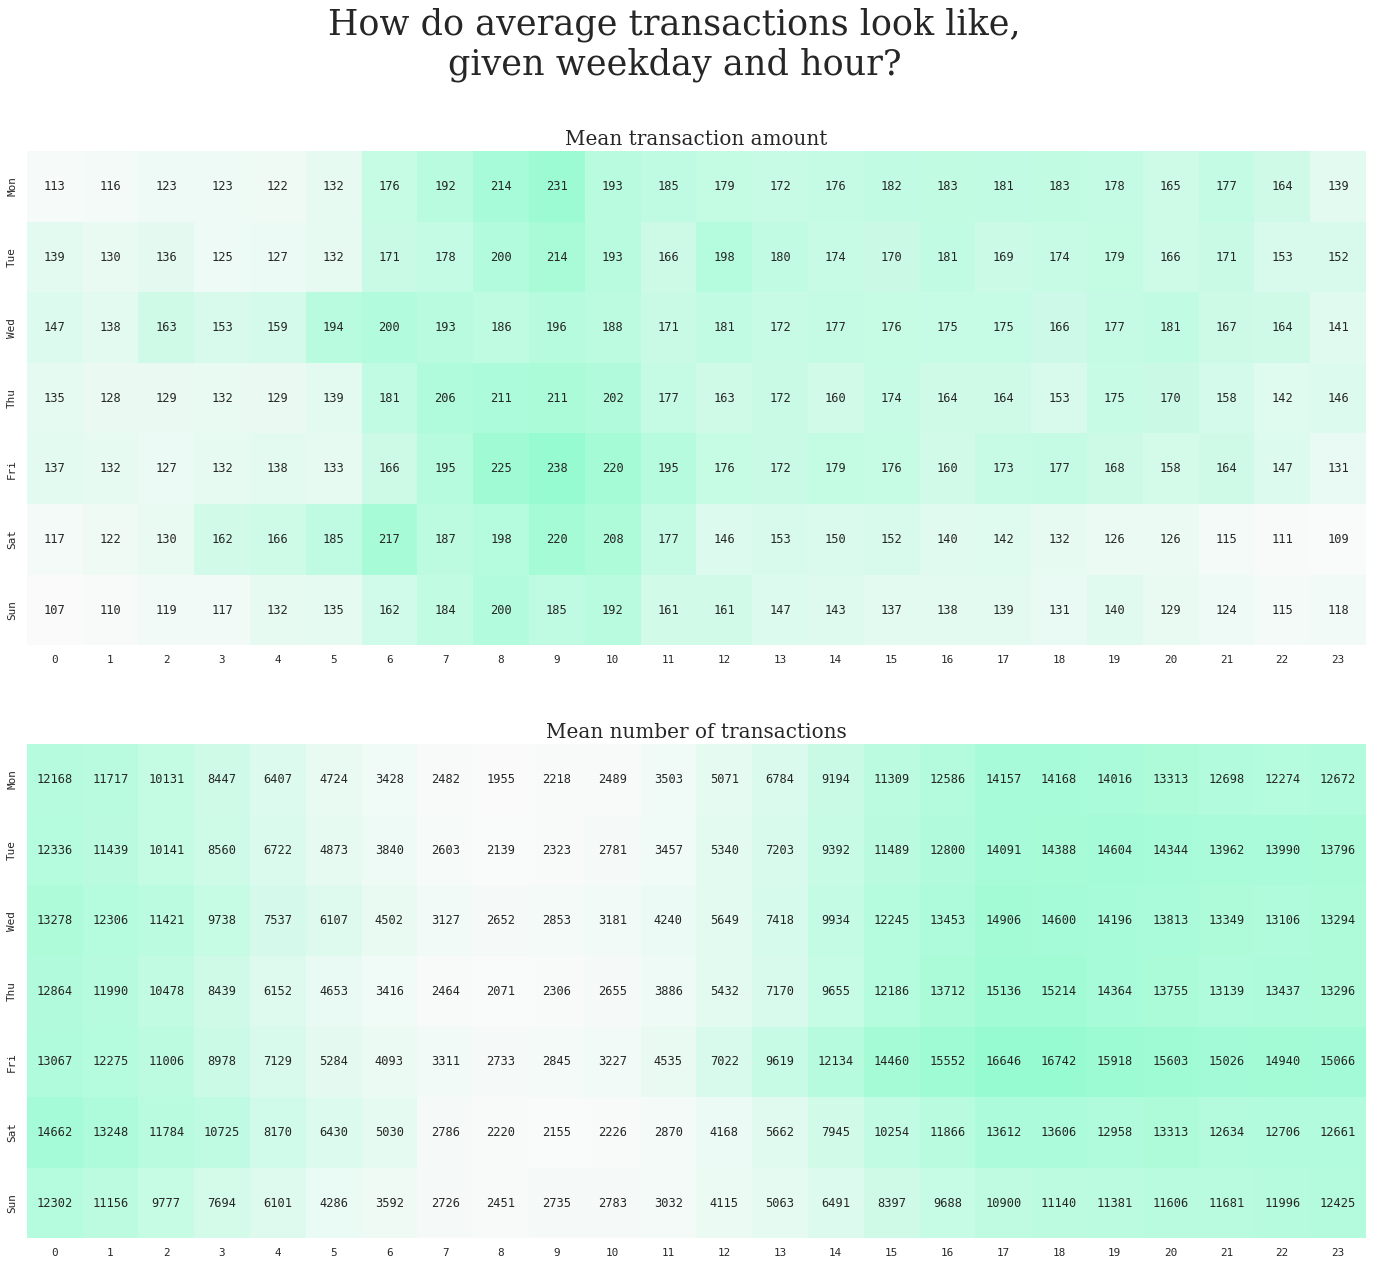

In [18]:
fig, axs = plt.subplots(2,1,figsize=(24,20), sharey=True)

hour_day_mean = data.groupby([data.time.dt.hour, data.time.dt.weekday]).amount_usd.mean().unstack().fillna(0)
sns.heatmap(hour_day_mean.T, annot=True, fmt='.3g', cmap=cmap_stripe_mono(), cbar=False, ax=axs[0])
axs[0].set_title('Mean transaction amount', fontsize=20, fontfamily='serif')
axs[0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axs[0].set_xlabel('')
axs[0].set_ylabel('')

hour_day_count = data.groupby([data.time.dt.hour, data.time.dt.weekday]).amount_usd.count().unstack().fillna(0)
sns.heatmap(hour_day_count.T, annot=True, fmt='.5g', cmap=cmap_stripe_mono(), cbar=False, ax=axs[1])
axs[1].set_title('Mean number of transactions', fontsize=20, fontfamily='serif')
axs[1].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axs[1].set_xlabel('')
axs[1].set_ylabel('')

plt.suptitle('How do average transactions look like,\ngiven weekday and hour?',
             fontsize=35,
             fontfamily='serif')

Most expensive purchases are happening in the morning and during work days.

Situation is reverse regarding the number of transactions. There is a way higher volume in the evening/night (5 pm - 2 am). Friday stand out, but otherwise there is no clear distinction between days of the week.

Now let's see how much merchants vary between each other in the amount of transactions they have on the weekend/evening vs other times.

First we filter out merchants that barely have any transactions. Otherwise it will appear for some that they have 100% on the weekend, but it was just a random one transaction.

In [19]:
merchants_at_least_20_trx = data.groupby(['merchant']).amount_usd.count()
merchants_at_least_20_trx = merchants_at_least_20_trx[merchants_at_least_20_trx>=20].index
len(merchants_at_least_20_trx) / data.merchant.nunique() * 100

38.05309734513274

Only about 38% of merchants had at least 20 total transactions.

Text(0.5, 0, '% of total amount')

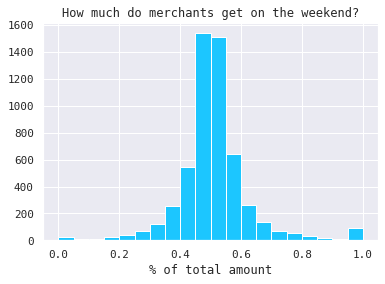

In [21]:
# Going out time: weeknd & after work work
data['is_weekend'] = (data.time.dt.weekday.isin([5,6]))
data['is_evening'] = (data.time.dt.hour.isin(list(range(0,4))+ list(range(18,24))))
data['is_going_out_time'] = (data['is_weekend'] | data['is_evening'])

weekday_merchant = data.query('merchant in @merchants_at_least_20_trx')\
    .groupby(['merchant', 'is_going_out_time']).amount_usd.mean().unstack().fillna(0)
weekday_merchant['pct_weekend'] = weekday_merchant[True]/ weekday_merchant.sum(1)

# Histogram
weekday_merchant.pct_weekend.hist(bins=20, color=any_stripe_colors(1))
plt.title('How much do merchants get on the weekend?')
plt.xlabel('% of total amount')

We see that most merchants get around 50% of their revenue on the weekend. There is a group that has 100% on the weekend though.

In [22]:
# are transactions concentred in specific months?
data_seasonal = data.query('merchant in @merchants_at_least_20_trx')\
    .groupby(['merchant', data.time.dt.to_period('M')]).count().time.unstack().fillna(0)

data_seasonal = data_seasonal.divide(data_seasonal.sum(1), axis=0)
data_seasonal.name = 'monthly_trx_count'

Text(0.5, 1.0, 'Max percentage of transactions in one month')

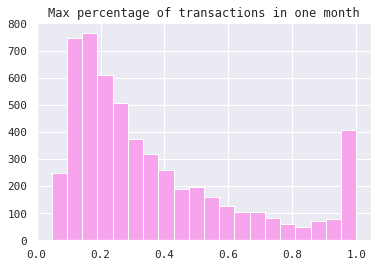

In [23]:
data_seasonal.max(1).hist(bins=20, color=any_stripe_colors(1))
plt.title('Max percentage of transactions in one month')

This needs more work. We should define seasons and assign each month to a season. Then see if, for exampe, summer season has more transactions. That could be a touristic business.

# Cohort Analysis

Let's do a brief cohort analysis of merchants. We define cohorts by the month they joined (first transaction).
We would like to see for merchants of each cohort how long they tend to stay with Stripe (last transaction date).

If the last transaction was in December 2024, we consider them active.

Text(0.5, 0, 'Number of merchants')

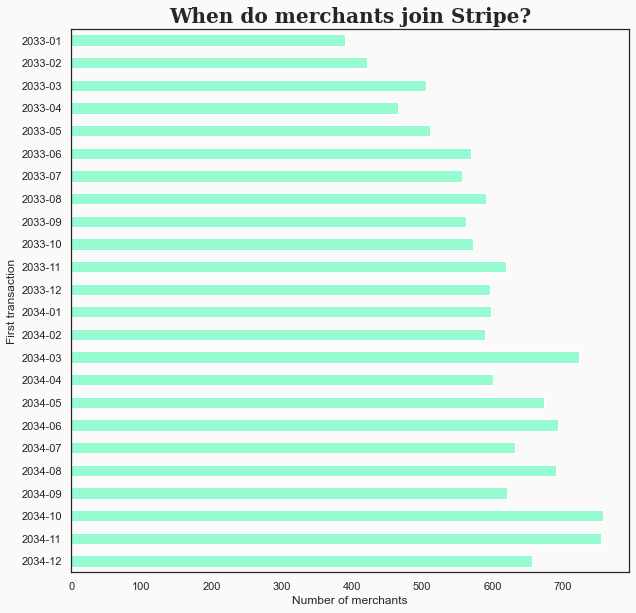

In [24]:
# Plot
sns.set_style(style='white')
colors = any_stripe_colors(2)
fig, ax = plt.subplots(1,1,figsize=(10,10))
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color) 

first_trx = data.groupby('merchant', as_index=False).time.min()\
    .rename(columns={'time':'time_first_trx'})
new_joiners = first_trx.groupby(first_trx.time_first_trx.dt.to_period('M')).count().merchant.iloc[::-1]
new_joiners.plot.barh(ax=ax, color=colors[0])

plt.title('When do merchants join Stripe?', fontsize=20, fontfamily='serif', fontweight='bold')
plt.ylabel('First transaction')
plt.xlabel('Number of merchants')

In [25]:
increase_since_2033 = (new_joiners.loc['2034-12'] - new_joiners.loc['2033-01'])/new_joiners.loc['2033-01'] * 100
print(f'There was a {round(increase_since_2033,2)}% increase in new monthly joiners since Jan 2033')

There was a 68.21% increase in new monthly joiners since Jan 2033


In [25]:
# create first transaction -> last transaction cohorts
cohorts = data.groupby(['merchant']).agg([min, max])\
    .time.rename(columns={'min':'first_trx_time', 'max':'last_trx_time'})
cohorts.first_trx_time = cohorts.first_trx_time.dt.to_period('M')
cohorts.last_trx_time = cohorts.last_trx_time.dt.to_period('M')
cohorts = cohorts.reset_index().groupby(['first_trx_time', 'last_trx_time']).count().unstack()
cohorts.columns = [c[1] for c in cohorts.columns]

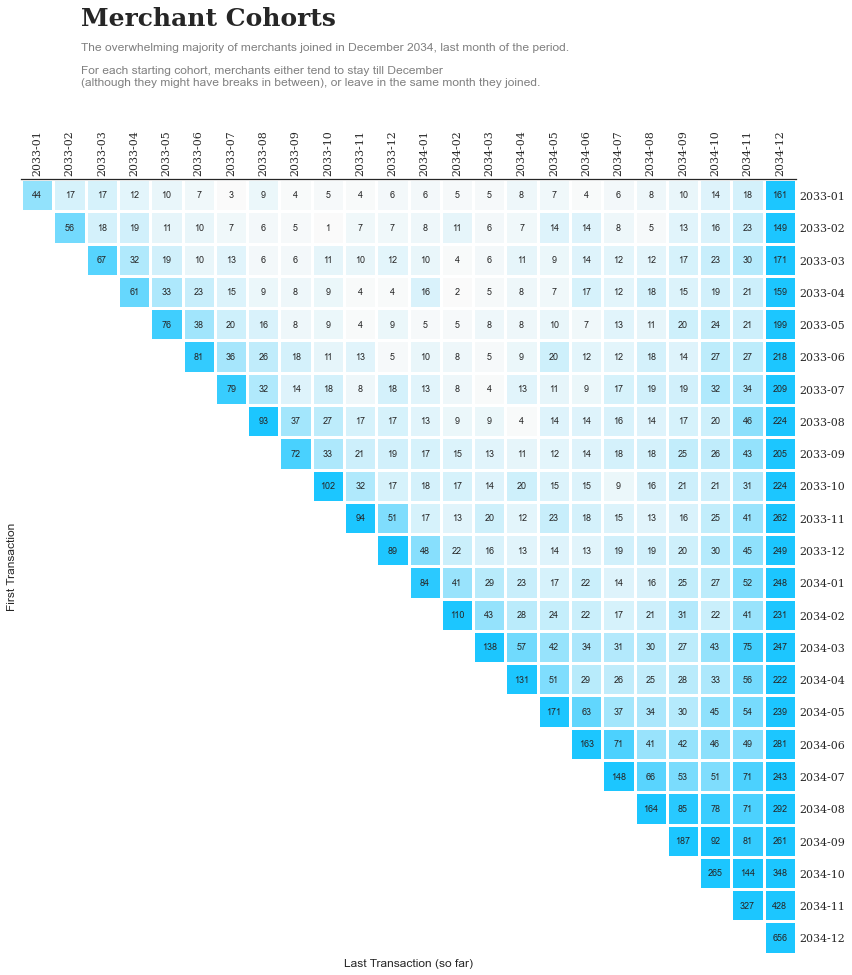

In [26]:
sns.set_style(style='white')
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)

sns.heatmap(cohorts, square=True, linewidth=2.5,cbar=False, cmap=cmap_stripe_mono(), vmax=90,vmin=3,
            annot=True,annot_kws={"fontsize":9}, ax=axs, fmt='.3g')
#axs.invert_yaxis()
axs.yaxis.tick_left()
axs.xaxis.tick_top()

axs.spines['top'].set_visible(True)

fig.text(0.1, 1.1, 'Merchant Cohorts', fontweight='bold', 
         fontfamily='serif', fontsize=25,ha='left', va='bottom')
annot_text = """
The overwhelming majority of merchants joined in December 2034, last month of the period.\n
For each starting cohort, merchants either tend to stay till December
(although they might have breaks in between), or leave in the same month they joined. 
"""
fig.text(0.1, 1.1, annot_text,
         fontfamily='sans', fontsize=12,ha='left', va='top', color='grey')   

axs.set_yticklabels(axs.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
axs.set_xticklabels(axs.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

axs.set_ylabel('First Transaction')    
axs.set_xlabel('Last Transaction (so far)')
axs.tick_params(axis=u'both', which=u'both',length=0)
axs.yaxis.tick_right()
plt.tight_layout()
plt.show()

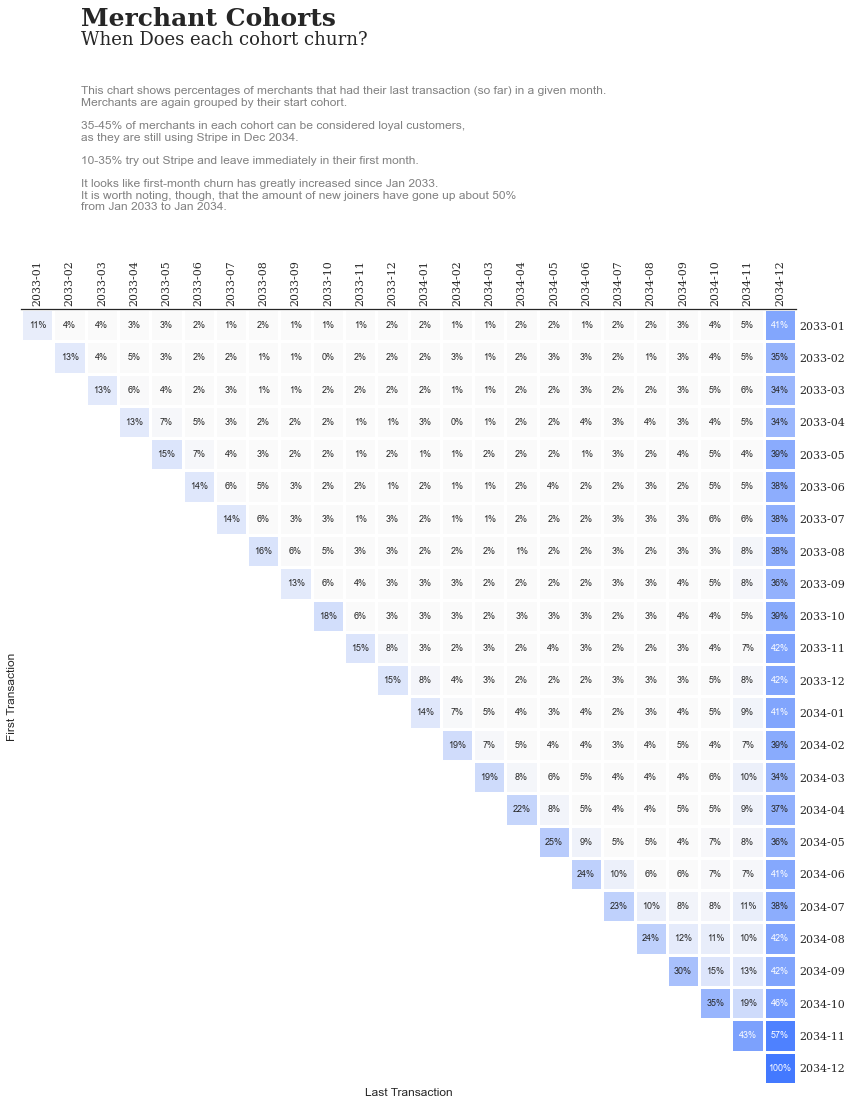

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)

sns.heatmap(cohorts.T.divide(cohorts.T.sum(0), axis=1).T, square=True, linewidth=2.5,cbar=False,
            cmap=cmap_stripe_mono(), vmin=0.06, vmax=0.6,
            annot=True,annot_kws={"fontsize":9}, ax=axs, fmt='1.0%')
axs.yaxis.tick_right()
axs.xaxis.tick_top()

axs.spines['top'].set_visible(True)


fig.text(0.1, 1.25, 'Merchant Cohorts', fontweight='bold', 
         fontfamily='serif', fontsize=25,ha='left', va='bottom')
fig.text(0.1, 1.25, 'When Does each cohort churn?', 
         fontfamily='serif', fontsize=18,ha='left', va='top')
annot_text = """
This chart shows percentages of merchants that had their last transaction (so far) in a given month.
Merchants are again grouped by their start cohort.

35-45% of merchants in each cohort can be considered loyal customers,
as they are still using Stripe in Dec 2034.

10-35% try out Stripe and leave immediately in their first month.

It looks like first-month churn has greatly increased since Jan 2033.
It is worth noting, though, that the amount of new joiners have gone up about 50%
from Jan 2033 to Jan 2034.
"""
fig.text(0.1, 1.2, annot_text,
         fontfamily='sans', fontsize=12,ha='left', va='top', color='grey')   

axs.set_yticklabels(axs.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
axs.set_xticklabels(axs.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

axs.set_ylabel('First Transaction')    
axs.set_xlabel('Last Transaction')
axs.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()

## Insights

**Loyal Customers** We see that most merchants stay for a very long time. For each starting cohort, about 35 to 45% percent of merchants are still active in the last month (December 2034). This group could represent loyal customers. Note, however, this does not mean that did did not have any breaks in between the joing date and December 2034. They could have some months without any transactions as all. We should dig deeper into this group and see waht is the average time between transactions for them.

**Unsuccessful Trial** The second biggest group is those that have their last transaction in the very same month as their first. Looks like they have tried out Stripe and decided it does not fit them. Depending on the reason they were trying out (just to check t or seriously considering a new payment perocessor), we may motivate them to stay by special offers.

In [28]:
def add_days_since_first_trx(gr):
    first_trx_date = gr.time.min()
    gr['days_since_first_trx'] = (gr.time - first_trx_date).dt.days
    return gr

data = data.groupby('merchant').progress_apply(lambda gr: add_days_since_first_trx(gr))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14351/14351 [00:05<00:00, 2473.74it/s]


Text(0.5, 0, 'How many months has passed since merchants first transaction')

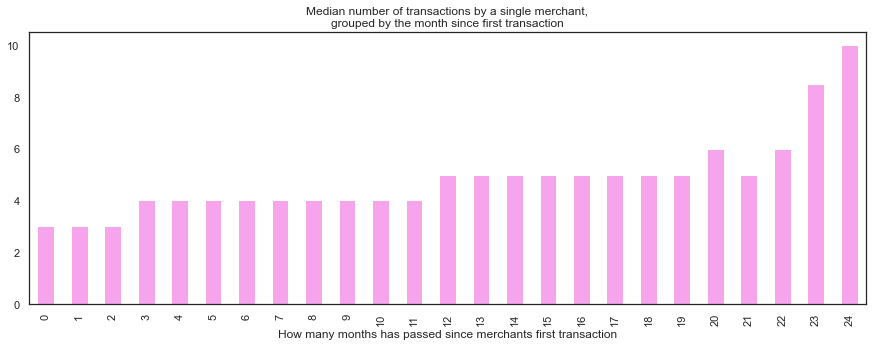

In [29]:
data['months_since_first_trx'] = (data.days_since_first_trx / 30).astype(int)

plt.figure(figsize=(15,5))
data.groupby(['merchant', 'months_since_first_trx']).count().time.groupby(level=1).median()\
    .plot.bar(color=any_stripe_colors(1))
plt.title('Median number of transactions by a single merchant,\ngrouped by the month since first transaction')
plt.xlabel('How many months has passed since merchants first transaction')

The longer merchants staty, the more transactions they have in a time window

In [30]:
first_month_churn = data.groupby('merchant').time.agg([min,max])
first_month_churn = first_month_churn[first_month_churn['min'].dt.to_period('M') ==\
                  first_month_churn['max'].dt.to_period('M')].index

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Average number of transactions\nfor merchants staying after the first month.')

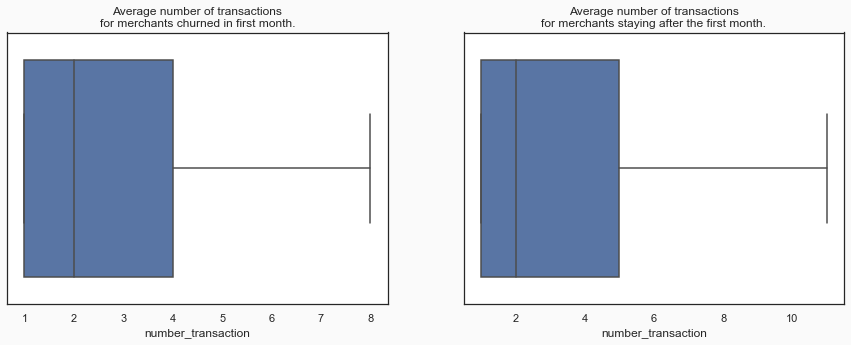

In [31]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
colors = any_stripe_colors(2)

first_month_churn_merchants = list(first_month_churn)
first_month_churned = data.query('merchant in @first_month_churn_merchants')\
    .groupby(['merchant', data.time.dt.to_period('M')])\
.days_since_last_trx.count().groupby(level=0).first()
first_month_churned.name = 'number_transaction'
sns.boxplot(first_month_churned, showfliers=False, ax=axs[0])
axs[0].set_title('Average number of transactions\nfor merchants churned in first month.')
#axs[0].set_xlim(0,20)

first_month_non_churned = data.query('merchant not in @first_month_churn_merchants')\
    .groupby(['merchant', data.time.dt.to_period('M')])\
.days_since_last_trx.count().groupby(level=0).first()
first_month_non_churned.name = 'number_transaction'
sns.boxplot(first_month_non_churned, showfliers=False, ax=axs[1])
axs[1].set_title('Average number of transactions\nfor merchants staying after the first month.')

We do not see a big difference between these two groups. Although those that churn in the first month do have a bit fewer transactions, on average, it is not a huge difference.

To verify the assumptions that those who churn in the first month have a different behavior, we can also compare these the groups through a nonparametric test like Mann-Whitney U Test. The Null hypothesis is that sample are drawn from the same distribution.

In [32]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(first_month_churned, first_month_non_churned)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=17375790.500, p=0.000
Different distribution (reject H0)


Based on the test, these two groups are different, and it's clear even in the first month. Shoudl we include some features for the first month?

# 1. Clustering Merchants

Let's assume now it's January 2035 and we have knowledge of everything happening in 2033-2034.

Features

* Timing & Counts
    * date of first transaction
    * days since first transaction
    * days between first and last
    * avg transaction count per week/month
    * avg trx count per day, on days with transactions
    * avg break between transactions (min | days)
    * std of transaction count in a week/month
    * transactions on weekend vs weekdays - weekend multiplier? + evevning
    
* Transaction Amount
    * std of transaction amount
    * #std deviations from an average transaction amount in that month (all merchant) -> sum (don't punish when everyone was doing badly, ie. crisis)
    
* Trend - is it a growing business or declining? vs first month, vs prev month
    * amount factor
    * frequency factor

In [34]:
def clip_values(df, percentile=90):
    """Clip features' values using a given percentile. Removes extreme outliers"""
    for col in df:
        clipped_val = np.percentile(df[col], percentile)
        df[col] = df[col].clip(df[col].min(), clipped_val)
    return df

### Feature Engineering

In [61]:
# Spearmann Correlation to describe trend
# longer to compute, hence a separate cell
spearman_corr_monthly = data.groupby(['merchant', data.time.dt.to_period('M')]).mean().amount_usd\
    .groupby(level=0).apply(lambda m: m.reset_index().drop('time', axis=1).reset_index()\
                            .corr(method="spearman").iloc[0].iloc[1]).fillna(0)
spearman_corr_monthly.name = 'spearman_corr_monthly'

In [62]:
# discribe first month
first_month_trx_count = data.groupby(['merchant', data.time.dt.to_period('M')])\
    .days_since_last_trx.count().groupby(level=0).first()
first_month_trx_median_amount = data.groupby(['merchant', data.time.dt.to_period('M')])\
    .amount_usd.median().groupby(level=0).first()

In [63]:
# features
# spearmann corr is computed above, as it takes longer to rerun than other feature computation

df_merchants = data.groupby('merchant')\
    .agg({'time': [min, max],
          'amount_usd': [np.std, np.median],
          'days_since_last_trx': [np.mean]}
        )
df_merchants.columns = ['first_trx_date', 'last_trx_date',
                        'std_trx_amount', 'median_trx_amount',
                        'mean_pause_days']

df_monthly_counts = data.groupby(['merchant', data.time.dt.to_period('M')]).count()\
    .time.groupby(level=0)\
    .agg([np.median, np.std])
df_monthly_counts.columns = ['monthly_median_trx_count', 'monthly_std_trx_count']

df_monthly_amount = data.groupby(['merchant', data.time.dt.to_period('M')]).mean()\
    .amount_usd.groupby(level=0)\
    .agg([np.median, np.std])
df_monthly_amount.columns = ['monthly_median_trx_amount', 'monthly_std_trx_amount']

# How much more profitable are weekends & after work hours compared to the rest
data['is_weekend'] = (data.time.dt.weekday.isin([5,6]))
data['is_evening'] = (data.time.dt.hour.isin(list(range(0,4))+ list(range(18,24))))
data['is_going_out_time'] = (data['is_weekend'] | data['is_evening'])
df_going_out = data.groupby(['merchant', 'is_going_out_time']).sum().amount_usd.unstack().fillna(0)
df_going_out['pct_amount_going_out_time'] = df_going_out[True] / df_going_out.sum(1)

skew_trx_amount = data.groupby(data.merchant).amount_usd.apply(lambda m: m.skew())
skew_trx_amount = skew_trx_amount
skew_trx_amount.name = 'skew_trx_amount'

# some features are unocommented now because they did not vary much by clusters
#.join(kurtosis_trx_amount.fillna(0))\
#.join(first_month_trx_count)\
#.join(first_month_trx_median_amount)\
#.join(data_seasonal)\
df_merchants = df_merchants\
    .join(df_going_out.pct_amount_going_out_time)\
    .join(skew_trx_amount)\
    .join(spearman_corr_monthly)\
    .fillna(0)

In [64]:
df_merchants['days_since_last_trx'] = df_merchants.last_trx_date.apply(lambda d: (datetime(2035,1,1) - d).days)
df_merchants['days_since_first_trx'] = df_merchants.first_trx_date.apply(lambda d: (datetime(2035,1,1) - d).days)
df_merchants['months_first_till_last_trx'] = (df_merchants['days_since_first_trx'] - df_merchants['days_since_last_trx'])/30

df_merchants = df_merchants.drop(['first_trx_date', 'last_trx_date'], axis=1)

In [65]:
df_merchants.shape

(14351, 9)

## Outliers
Our data has some quite large outliers, especially in features related to transaction amount. To handle this, we first focus on median instead of mean. Then, we are also clipping values using 95th percentile. That will remove the most extreme values.

When goven more time, we could explore other ways, such as using linear extrapolation to fill the values. 

In [66]:
df_merchants = clip_values(df_merchants, percentile=95)

scaler = StandardScaler()
df_merchants = pd.DataFrame(scaler.fit_transform(df_merchants),
                            index=df_merchants.index, columns=df_merchants.columns)

## Selecting optimal number of clusters for K-Means algorithm

We are using **K-Means** and the **Elbow Method** to select the number of clusters.


In the Elbow method, we are actually varying the number of clusters between 1 and 15, to see which works best.

For each value of K, we are calculating WCSS (_Within-Cluster Sum of Square_). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1. When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape. The K value corresponding to this point is the optimal K value or an optimal number of clusters.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.36it/s]


<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

<Figure size 1050x450 with 0 Axes>

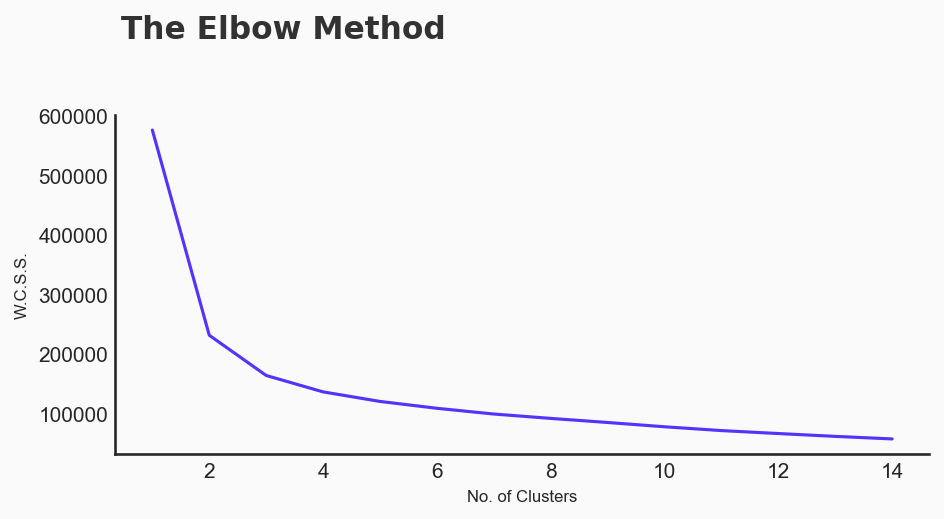

In [48]:
def elbow_method_knn(X, min_cls=1, max_cls=15):
    wcss = []
    for i in tqdm(range(min_cls, max_cls)):
        km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 20, n_init = 10, random_state = 0)
        km.fit(X)
        wcss.append(km.inertia_)
        fig = plt.figure(figsize=(7,3),dpi=150)
    gs = fig.add_gridspec(1, 1)
    gs.update(wspace=0.05, hspace=0.27)
    ax0 = fig.add_subplot(gs[0, 0])
    colors = any_stripe_colors(2)

    background_color = "#fafafa"
    fig.patch.set_facecolor(background_color)
    ax0.set_facecolor(background_color) 
    for s in ['top','right']:
        ax0.spines[s].set_visible(False)

    fig.text(0.13,1.05,'The Elbow Method',fontfamily='sansserif',fontweight='bold',fontsize=15,color='#323232')

    plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
    plt.tick_params(axis=u'both', which=u'both',length=0)

    plt.plot(range(min_cls, max_cls), wcss,color=colors[1])
    plt.xlabel('No. of Clusters',fontsize=8)
    plt.ylabel('W.C.S.S.',fontsize=8)
    
elbow_method_knn(df_merchants, 1,15)

Looks like it would be best to select ahigher number of clusters, at least 14. However, for the sake of simplicity and havng enough time to analyse the clusters, we will try out 6. 

In the future it would be best to try a higher number and see if the created clusters are meaningful for the business.

In [67]:
# Create clusters
X = df_merchants
kmeans = KMeans(n_clusters=6, random_state=11)
X["cluster"] = kmeans.fit_predict(X)

df_merchants['cluster'] = X["cluster"]#.astype("category")

counts = df_merchants.groupby('cluster').count().mean_pause_days

<AxesSubplot:ylabel='cluster'>

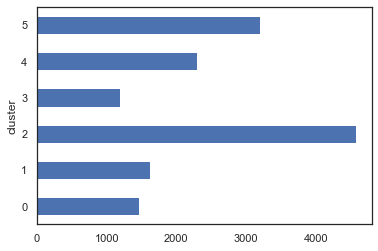

In [68]:
counts.plot.barh()

In [57]:
# uncomment to save clustering results
# df_merchants[['cluster']].reset_index().to_csv('merchant_clusters.csv')

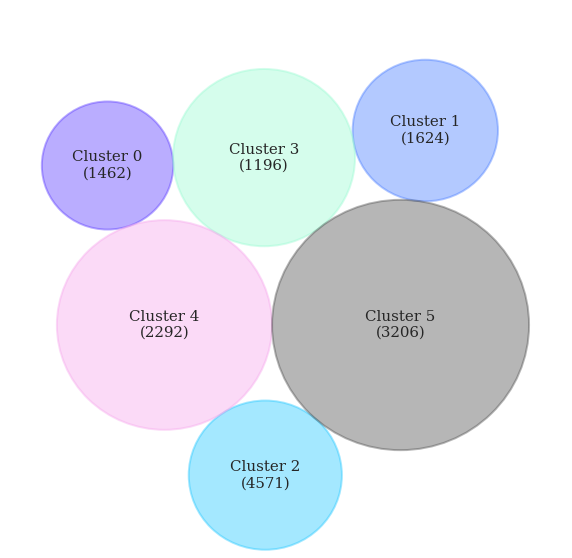

In [69]:
# https://www.python-graph-gallery.com/circular-packing-1-level-hierarchy
import circlify
cluster_values = df_merchants.groupby('cluster').count().mean_pause_days

# compute circle positions:
circles = circlify.circlify(
    list(cluster_values), 
    show_enclosure=True, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(10,10))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = cluster_values.index
labels = [f'Cluster {i}' for i in labels]

# print circles
for circle, label, color, val in zip(circles, labels, STRIPE_COLORS + ['#4a4a4a'], list(cluster_values)):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.4, linewidth=2, color=color))
    plt.annotate(
          label + f'\n({val})', 
          (x,y ) ,
          va='center',
          ha='center',
        fontsize=15, 
        fontfamily='serif'
     )

# PCA to visualize clusters

We try out PCA, one of the common methods to visualize high-dimensional data.
We project our 11 features into a smaller-dimensional space, using either 2 or 3 compoenets.

<IPython.core.display.Javascript object>

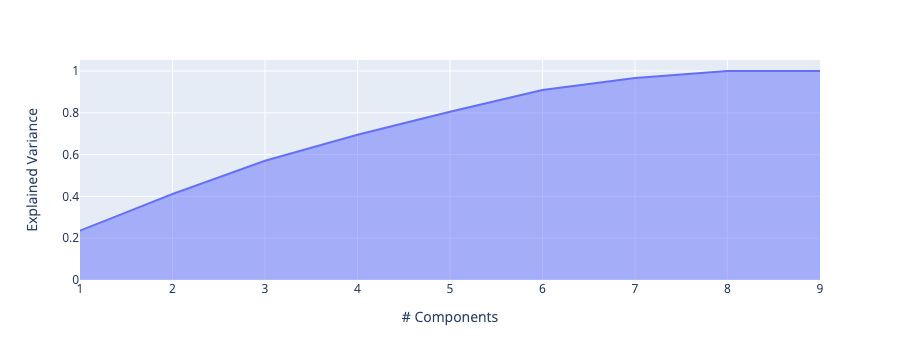

In [70]:
pca = PCA()
pca.fit(df_merchants.drop('cluster', axis=1))
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

This indicates that we need just 2 components to explain almost 80% of variance, Let's try 3 with a 3D plot in plot;y. It accounts for about 61% of variance, but at least we can visually inspect the clusters with 3 components.

100% is achieved at 11 components, which is our total number of features.

<IPython.core.display.Javascript object>

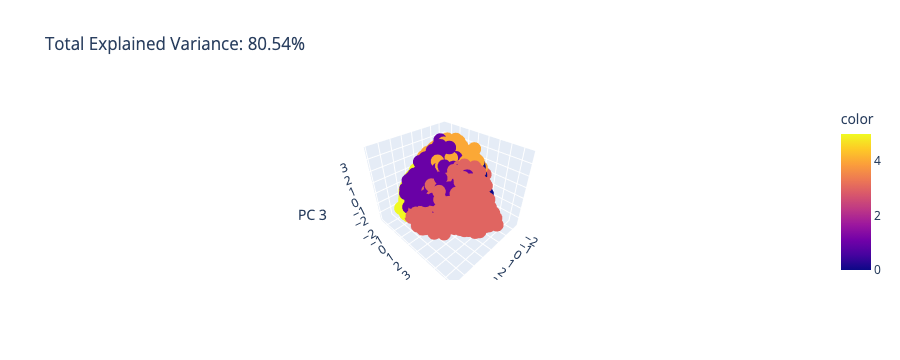

In [93]:
pca = PCA(5)
principalComponents = pca.fit_transform(df_merchants.drop('cluster', axis=1))

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    principalComponents, x=0, y=1, z=2, color=df_merchants['cluster'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

We see that there is no complete separation, and clusters 4 and 6 are crambled together.
However, the rest are not doing to bad. 

The worst case is cluster 4, whose points are intermingled in the general area of clusters 6 and 2.
Also, although we can clearly separate clusters on the outside (surface of the 3D shape), it looks like inside it's way more messy. Perhaps clusters are separated by theor outliers, but they smaller values are too similar?

Let's take a look at a 2D-projection as well

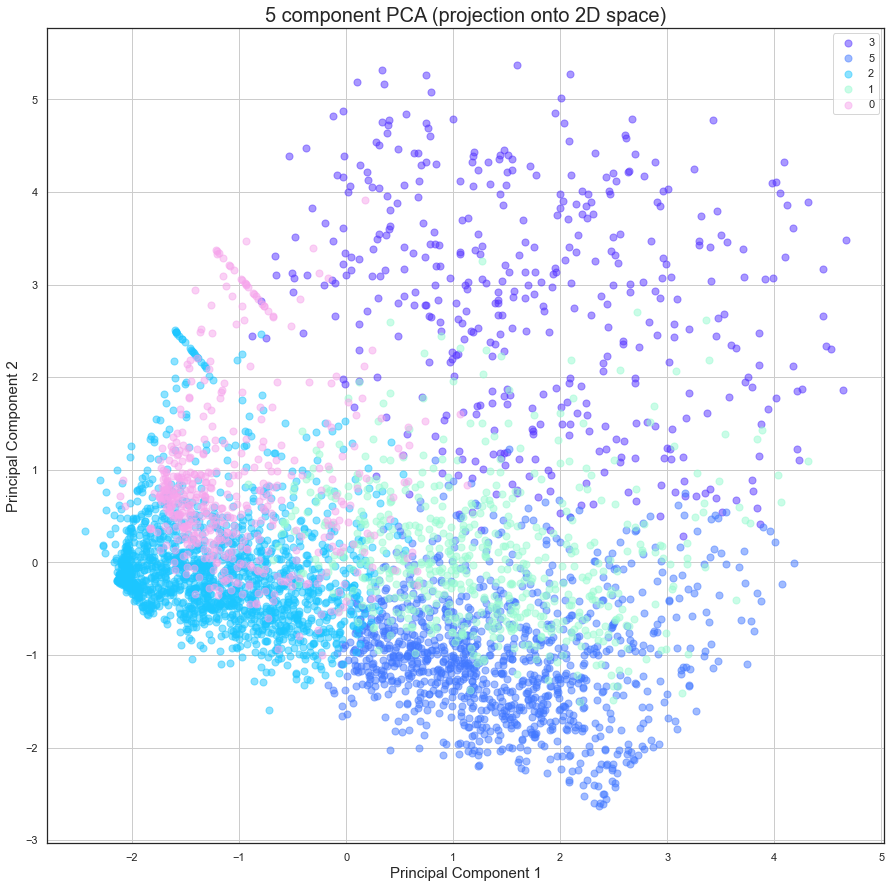

In [94]:
def plot_pca_2d(n_components=2, sample=5000):
    """Plot 2D projection of a PCA algorithm. Can limit sample size for clear visuals"""
    pca = PCA(n_components)
    cols = ['pca'+str(i+1) for i in range(n_components)]
    principalComponents = pca.fit_transform(df_merchants.drop('cluster', axis=1))
    principalDf = pd.DataFrame(data = principalComponents
                 , columns=cols)
    finalDf = pd.concat([principalDf, df_merchants[['cluster']].reset_index(drop=True)], axis = 1)
    
    if sample is not None:
        sample = finalDf.sample(sample)
    
    colors = STRIPE_COLORS
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(f'{n_components} component PCA (projection onto 2D space)', fontsize = 20)
    
    clusters = sample['cluster'].unique()
    for cluster, color in zip(clusters,colors):
        indicesToKeep = sample['cluster'] == cluster
        ax.scatter(sample.loc[indicesToKeep, 'pca1']
                   , sample.loc[indicesToKeep, 'pca2']
                   , c = color
                   , s = 50,
                  alpha=0.5)
    ax.legend(clusters)
    ax.grid()
    
plot_pca_2d(5, sample=5000)

In [95]:
def get_cluster_trx(cluster):
    """Helper function. Get all transactional data for a certain cluster."""
    cluster_merchants = df_merchants.query(f'cluster == {cluster}').index
    return data.query('merchant in @cluster_merchants')

In [96]:
# scaling features to the right scale
df_merchants[[col for col in df_merchants.columns if col != 'cluster']] =\
    scaler.inverse_transform(df_merchants[[col for col in df_merchants.columns if col != 'cluster']])

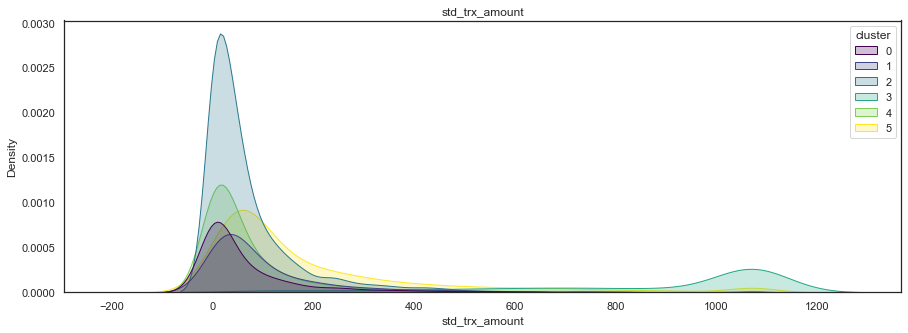

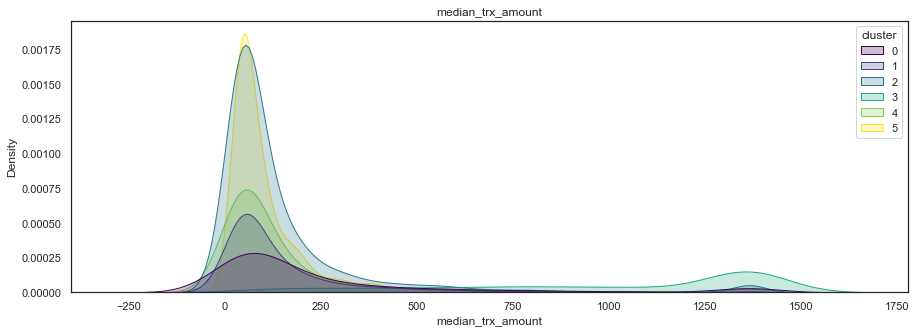

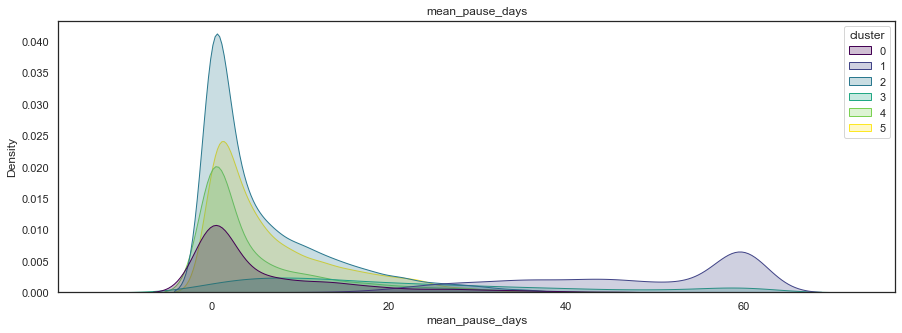

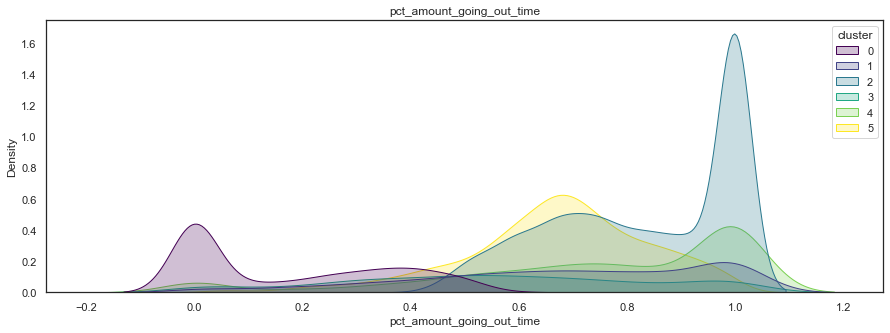

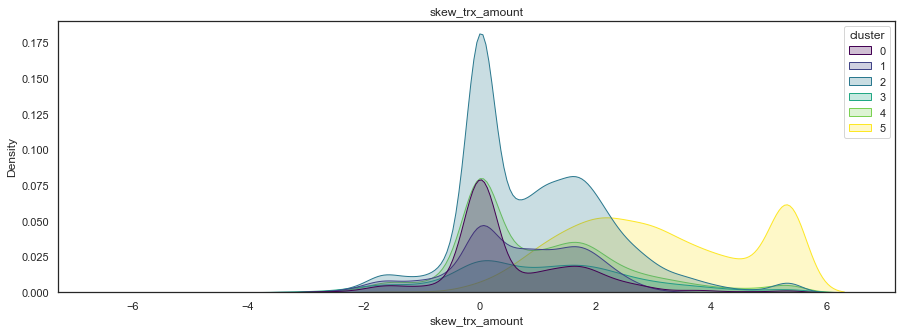

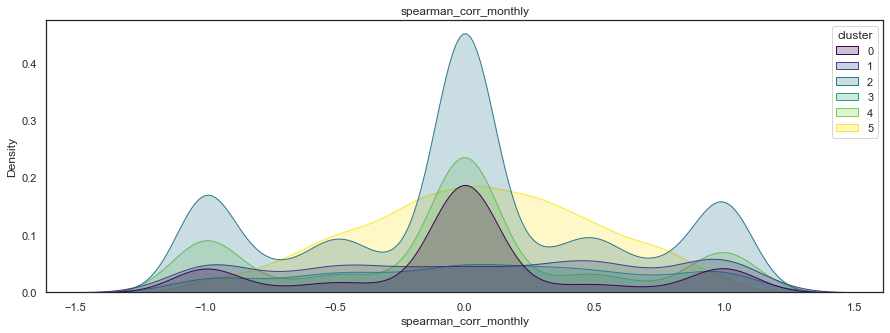

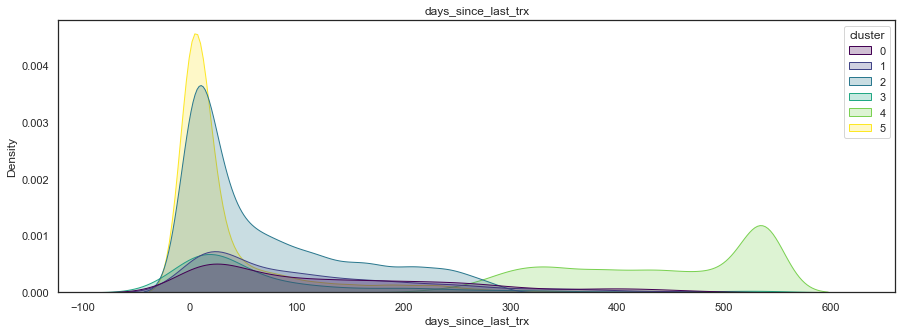

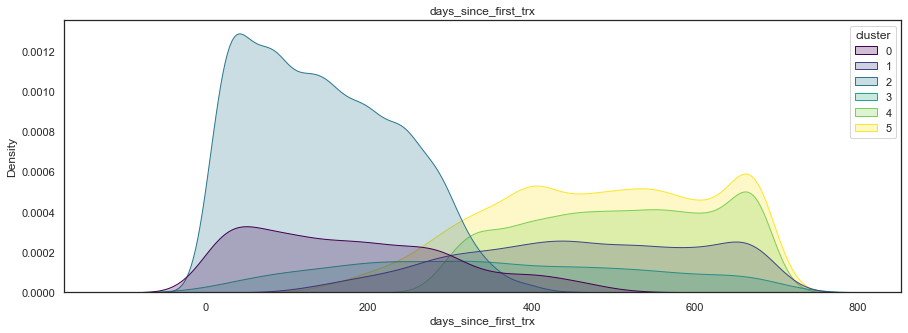

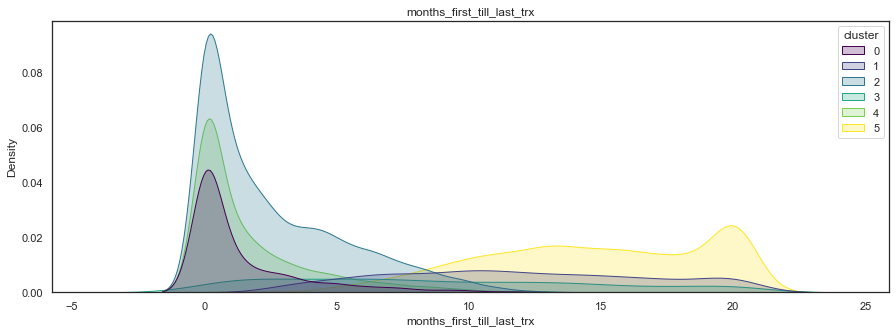

In [99]:
for feature in X[[col for col in X.columns if col != 'cluster']].columns:
    plt.figure(figsize=(15,5))
    plt.title(feature)
    sns.kdeplot(data=X, hue='cluster', x=feature,shade=True, palette=sns.color_palette("viridis", as_cmap=True))

# 2. Predicting Churn

## Definition

It's clear that churn implies no transactional activity _in a certain period_ (it is impractical to define "churn" as a customer **never** coming back, since then we could not actually compute a metric).

Should we focus on one day, week, month, year? A week or day sounds too volatile. It is not too strange to go a week without a transaction, and for some business it can be a given. We would be overpredicting churn for customers with longer breaks.

We can say, for example, that a merchant curns when they have zero transactions in the last 30 days. But do all business process transactions every month? As we saw above, there are some businesses that have way longer breaks, very infrequent transactions.

If a merchant had a period with more or less frequent transactions, but stopped for a while and then come back


To understand if 30 days is appropriate to use as a break, let's see how much time passes between transaction usually.
First, we need to remove the very last transaction 

In [54]:
data[data.days_since_last_trx < 30].shape[0] / data.shape[0]

0.9887938250097937

In [103]:
data[data.days_since_last_trx > 7].shape[0] / data.shape[0]

0.0397524243271043

In [105]:
# 50% of merchants churned at some point by this definition
data[data.days_since_last_trx > 30].merchant.nunique() / data.merchant.nunique()

0.48867674726499893

In almost 99% of cases there was less than 30 days break between transaction. Let's look at those with a break longer than a month. Is there anything speacial about them?

However, almost 50% of merchants have churned by this definition, at some point. How many of them came back?

Text(0.5, 1.0, 'How many times does one merchant churn?')

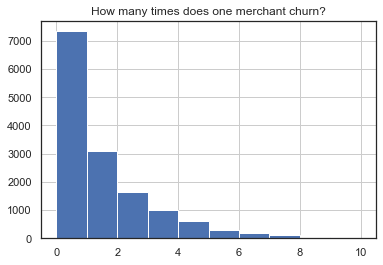

In [109]:
data['is_churn'] = (data.days_since_last_trx > 30)

count_churns = data.groupby('merchant').is_churn.sum()
count_churns.hist(bins=10)
plt.title('How many times does one merchant churn?')

Most merchants churn only once, but some do 2 or more. Let's look at the timeline of their transactions. We take a sample of 20 merchants from every group:
* never churned or had a final churn (never came back)
* churned once and came back
* churned more than once

In [110]:
def plot_merchants_transactions(merchant_list):
    """Plot transactions timeline to visualize breaks."""
    fig, ax = plt.subplots(1,1,figsize=(20,1*len(merchant_list)))
    sns.set_style(style='white')
    background_color = "#fafafa"
    fig.patch.set_facecolor(background_color) # figure background color
    ax.set_facecolor(background_color) 
    
    for i, m in enumerate(merchant_list):
        sns.scatterplot(data=data.query(f'merchant == "{m}"'), y=i, x='days_since_first_trx',
                        size='amount_usd',
                       legend=None, label=m, ax=ax)
        ax.set_ylabel('')
    #ax.set_xlim(-5,365)
    ax.set_xlabel('Number of days since the first transaction', fontsize=20)

Each horizontal line (x=i) represents a single merchant.

x=0 represents time of the first transaction for each merchant. 

y-axis represents days since the very first transaction.

(-10.0, 100.0)

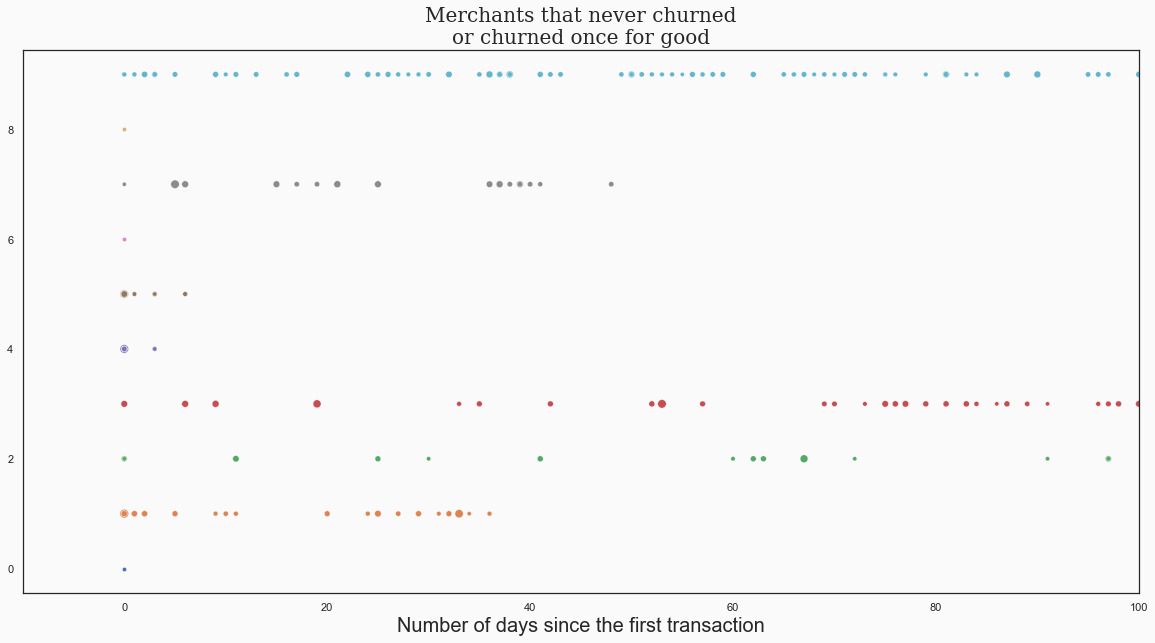

In [111]:
# those that churned just once
plot_merchants_transactions(np.random.choice(count_churns[count_churns==0].index, size=10))
plt.title('Merchants that never churned\nor churned once for good', fontfamily='serif', fontsize=20)
plt.xlim(-10,100)

We see that some have very regular transactions (with max a few days in between).
Others have just some transctions in the very first month, but drop away soon after. Perhaps they were never intending to stay and were just playing around, perhaps something in the payment platform was not for them. 

It is important to distinguish these two, as the later group might be retained if we understand their wishes better.

NOTE: These merchants either leave immediately in the first month, or suddenly drop off at some point. It is interesting that there was no real steady decline in transaction frequency till zero transactions.

Text(0.5, 1.0, 'Merchants that churned only once & came back')

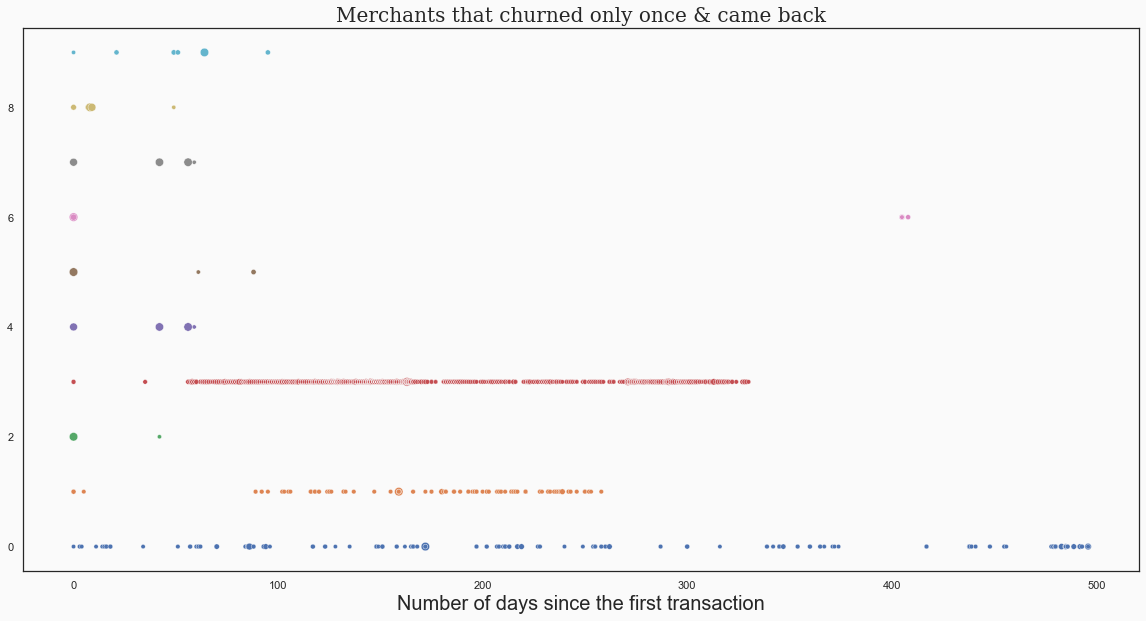

In [112]:
plot_merchants_transactions(np.random.choice(count_churns[count_churns==1].index, size=10))
plt.title('Merchants that churned only once & came back', fontfamily='serif', fontsize=20)

Now we see that the merchants that had over 30 days break, but come back at some point to have more transctions. Sometimes they have several periods with frequent transactions. Othertimes just some sporadic burst of several transactions before stopping again.

We can consider these merchants churned the first time, and then treat them as new joiners when they come back again.

Text(0.5, 1.0, 'Merchants that churned at least twice')

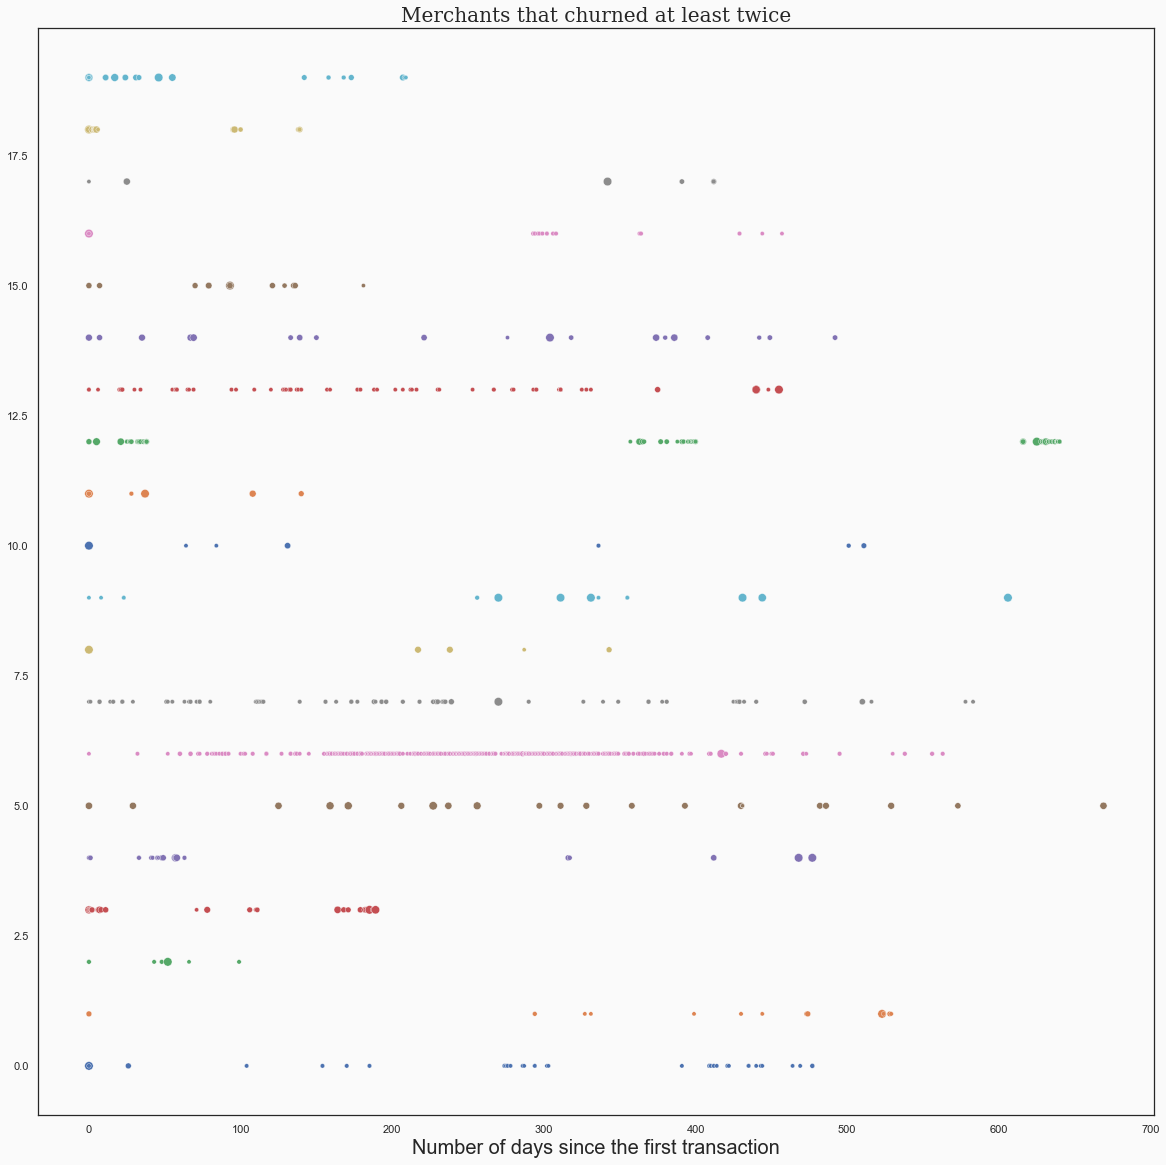

In [60]:
plot_merchants_transactions(np.random.choice(count_churns[count_churns>1].index, size=20))
plt.title('Merchants that churned at least twice', fontfamily='serif', fontsize=20)

Some of these merchants show repetetive behavior. They repeat a transaction pattern when coming back after a longer break. We need to pay special attention to them. If we can identify them, we can define churn differntly for such merchants. It could be businesses that only sell products in a certain season, or haev large orders every few months.

They did not necessarily leave Stripe, it is just a different business model from normal consumer market. For example, construction industry that has large order that take a wile to complete.

For now for the sake of simplicity we will consider all those who has at least 30 days wihout any transction churned. If a merchant comes back after 30 days, we will treat him as a new merchant (kind of having a new subscription after canclling a previous one). Of course, we know more about come-back merchants than a true "new joiners" that never used Stripe. The past data should be utilized in case merchants come back. But we will leave it out of this assignment due to being short on time.

## Predictions

1. For **new joiners** (30 days since the first transction or less), we do not have any transaction history. We can assign them a churn probability of the starting cohort. We can use an averag of the last few months, since Stripe has way higher initial customer acquisition in late 2035 than early 2033, and it is still growing. It goes hand to hand with increased churn in the very first month though. 

    For example, if now is Jan 2035, we we look at what percentage of new joiners in September, October and November 2034 had no transactions in their second month. We could also do a time series to account fo rmonthly seasonality instead of taking average of teh last months.
    
2. For others, we use predictions of the XGBoost model.

In [117]:
data = data_raw.copy()
data['amount_usd'] = data.amount_usd_in_cents / 100
data.drop(['amount_usd_in_cents'], axis=1, inplace=True)

data = data.groupby('merchant').progress_apply(lambda merchant_trx: calculate_time_between_trx(merchant_trx))
data.drop(['months_since_last_trx', 'min_since_last_trx'], axis=1, inplace=True)

data['is_churn'] = (data.days_since_last_trx > 30)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14351/14351 [00:16<00:00, 886.81it/s]


In [118]:
# Define "subscriptions" - period where no transaction was later than 30 days from the prious one
# once this rule breaks, and if a merchant comes back, a new subscription starts

def get_subscription_number(gr):
    gr['subscription'] = gr.is_churn.cumsum()
    return gr

data = data.groupby('merchant')\
    .progress_apply(lambda gr: get_subscription_number(gr))
data = data[['merchant', 'subscription', 'time', 'amount_usd', 'days_since_last_trx', 'is_churn']]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14351/14351 [00:03<00:00, 3591.09it/s]


In [119]:
def days_since_last_trx_sub(sub):
    """Calculate days passed since last transction for this subscription"""
    time_shift = (sub.time - sub.time.shift(1))
    sub['days_since_last_sub_trx'] = time_shift.dt.days
    return sub.fillna(0)

GROUPBY = ['merchant', 'subscription']
data = data.groupby(GROUPBY).progress_apply(lambda sub_trx: days_since_last_trx_sub(sub_trx))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30094/30094 [00:23<00:00, 1294.43it/s]


In [120]:
# subscriptions churns -> new sub created
# or when more than 30 days has passed from the last sub transaction till now
data['is_sub_churn'] = data.is_churn

In [121]:
CURRENT_DATE = datetime(2034,9,1)
ONE_MONTH_AGO = datetime(2034,8,1)
IN_ONE_MONTH = datetime(2034,10,1)

In [122]:
data_train = data[data.time <= CURRENT_DATE]
active_subs = data_train[data_train.time >= ONE_MONTH_AGO][['merchant', 'subscription']].drop_duplicates()
data_train = active_subs.merge(data_train, on=GROUPBY, how='left')

In [181]:
def add_features(df, cutoff_date):
    """Calculate the same features as for clustering, but grouping by subscription instead."""
    spearman_corr_monthly = df.groupby([*GROUPBY, df.time.dt.to_period('M')]).mean().amount_usd\
        .groupby(level=0).apply(lambda m: m.reset_index().drop('time', axis=1).reset_index()\
                                .corr(method="spearman").iloc[0].iloc[1]).fillna(0)
    spearman_corr_monthly.name = 'spearman_corr_monthly'

    # discribe first month
    first_month_trx_count = df.groupby([*GROUPBY, df.time.dt.to_period('M')])\
        .days_since_last_trx.count().groupby(level=0).first()
    first_month_trx_median_amount = df.groupby(['merchant', df.time.dt.to_period('M')])\
        .amount_usd.median().groupby(level=0).first()

    df_subs = df.groupby(GROUPBY)\
        .agg({'time': [min, max],
              'amount_usd': [np.std, np.median],
              'days_since_last_trx': [np.mean]}
            )
    df_subs.columns = ['first_trx_date', 'last_trx_date',
                            'std_trx_amount', 'median_trx_amount',
                            'mean_pause_days']

    df_monthly_counts = df.groupby([*GROUPBY, df.time.dt.to_period('M')]).count()\
        .time.groupby(level=0)\
        .agg([np.mean, np.std])
    df_monthly_counts.columns = ['monthly_mean_trx_count', 'monthly_std_trx_count']

    df_monthly_amount = df.groupby([*GROUPBY, df.time.dt.to_period('M')]).mean()\
        .amount_usd.groupby(level=0)\
        .agg([np.mean, np.std])
    df_monthly_amount.columns = ['monthly_mean_trx_amount', 'monthly_std_trx_amount']

    # How much more profitable are weekends & after work hours compared to the rest
    df['is_weekend'] = (df.time.dt.weekday.isin([5,6]))
    df['is_evening'] = (df.time.dt.hour.isin(list(range(0,4))+ list(range(18,24))))
    df['is_going_out_time'] = (df['is_weekend'] | df['is_evening'])
    df_going_out = df.groupby([*GROUPBY, 'is_going_out_time']).sum().amount_usd.unstack().fillna(0)
    df_going_out['pct_amount_going_out_time'] = df_going_out[True] / df_going_out.sum(1)
    
    skew_trx_amount = df.groupby(GROUPBY).amount_usd.apply(lambda m: m.skew())
    skew_trx_amount = skew_trx_amount
    skew_trx_amount.name = 'skew_trx_amount'

    df_subs = df_subs\
        .join(df_going_out.pct_amount_going_out_time)\
        .join(skew_trx_amount)\
        .join(spearman_corr_monthly)\
        .fillna(0)
    
    df_subs['days_since_last_trx'] = df_subs.last_trx_date.apply(lambda d: (cutoff_date - d).days)
    df_subs['days_since_first_trx'] = df_subs.first_trx_date.apply(lambda d: (cutoff_date - d).days)
    df_subs['months_first_till_last_trx'] = (df_subs['days_since_first_trx'] -\
                                                  df_subs['days_since_last_trx'])/30

    df_subs = df_subs.drop(['first_trx_date', 'last_trx_date'], axis=1)

    df_subs = clip_values(df_subs)
    
    return df_subs
    
df_subs = add_features(data_train, cutoff_date=CURRENT_DATE)

In [124]:
# scaling
scaler = StandardScaler()
df_subs = pd.DataFrame(scaler.fit_transform(df_subs),
                            index=df_subs.index, columns=df_subs.columns)
df_subs.head()

std_trx_amount  median_trx_amount  mean_pause_days  \
merchant   subscription                                                       
000ed1585f 4                  -0.375085           0.195651        -0.057421   
000f8c3297 0                  -0.145492          -0.547622        -0.677892   
002a66c0e1 0                  -0.353727           0.832357        -0.575664   
003d24c5d3 0                  -0.485056          -0.531898        -0.428655   
004a994585 2                   0.112030           0.472994         0.579357   

                         pct_amount_going_out_time  skew_trx_amount  \
merchant   subscription                                               
000ed1585f 4                             -0.157334        -0.572833   
000f8c3297 0                             -0.955838        -0.096365   
002a66c0e1 0                             -0.093878        -0.915950   
003d24c5d3 0                              0.267733        -0.385722   
004a994585 2                              1.140923        -1.038890   

                         spearman_corr_monthly  days_since_last_trx  \
merchant   subscription                                               
000ed1585f 4                               0.0             0.267911   
000f8c3297 0                               0.0            -0.223995   
002a66c0e1 0                               0.0            -0.346972   
003d24c5d3 0                               0.0            -0.715901   
004a994585 2                               0.0            -0.715901   

                         days_since_first_trx  months_first_till_last_trx  
merchant   subscription                                                    
000ed1585f 4                        -0.462080                   -0.464987  
000f8c3297 0                         1.980963                    1.954879  
002a66c0e1 0                         1.058231                    1.062446  
003d24c5d3 0                        -0.620263                   -0.550798  
004a994585 2                        -0.866325                   -0.791068

In [125]:
targets = data[(data.time >= CURRENT_DATE) & (data.time < IN_ONE_MONTH)]
targets = active_subs.merge(targets, on=GROUPBY, how='left').fillna(1)
targets.is_sub_churn = targets.is_sub_churn.astype(int)
targets = targets.groupby(GROUPBY).sum().is_sub_churn

targets.name = 'churned'

df_subs = df_subs.join(targets, how='left').fillna(1)

In [126]:
df_subs.churned.value_counts()

0    3514
1    1661
Name: churned, dtype: int64

In [127]:
targets.isnull().sum()

0

In [182]:
GROUPBY = ['merchant', 'subscription']

class ChurnFeatureGenerator:
    def __init__(self, data, cutoff_date):
        self.data = data
        self.cutoff_date = cutoff_date
        
        self.df_subs = None
        
    @staticmethod
    def clip_values(df, percentile=90):
        """Clip features' values using a given percentile. Removes extreme outliers"""
        for col in df:
            clipped_val = np.percentile(df[col], percentile)
            df[col] = df[col].clip(df[col].min(), clipped_val)
        return df
        
    def add_basic_features(self):
        print('Adding transaction amount features features')
        self.df_subs = self.data.groupby(GROUPBY)\
            .agg({'time': [min, max],
              'amount_usd': [np.std, np.median],
              'days_since_last_trx': [np.mean]}
            )
        self.df_subs.columns = ['first_trx_date', 'last_trx_date',
                                'std_trx_amount', 'median_trx_amount',
                                'mean_pause_days']
        
    def add_trend_features(self):
        print('Adding trend features')
        spearman_corr_monthly = self.data.groupby([*GROUPBY, self.data.time.dt.to_period('M')]).mean().amount_usd\
        .groupby(level=0).apply(lambda m: m.reset_index().drop('time', axis=1).reset_index()\
                                .corr(method="spearman").iloc[0].iloc[1]).fillna(0)
        spearman_corr_monthly.name = 'spearman_corr_monthly'
        self.df_subs = self.df_subs.join(spearman_corr_monthly)
        
    def add_first_month_features(self):
        print('Adding first month features')
        # discribe first month
        first_month_trx_count = self.data.groupby([*GROUPBY, self.data.time.dt.to_period('M')])\
            .days_since_last_trx.count().groupby(level=0).first()
        first_month_trx_median_amount = self.data.groupby(['merchant', self.data.time.dt.to_period('M')])\
            .amount_usd.median().groupby(level=0).first()
        self.df_subs = self.df_subs.join(first_month_trx_median_amount)\
            .join(first_month_trx_count)
        
    def add_monthly_features(self):
        print('Adding monthly features')
        df_monthly_counts = self.data.groupby([*GROUPBY, self.data.time.dt.to_period('M')]).count()\
            .time.groupby(level=0)\
            .agg([np.mean, np.std])
        df_monthly_counts.columns = ['monthly_mean_trx_count', 'monthly_std_trx_count']

        df_monthly_amount = self.data.groupby([*GROUPBY, self.data.time.dt.to_period('M')]).mean()\
            .amount_usd.groupby(level=0)\
            .agg([np.mean, np.std])
        df_monthly_amount.columns = ['monthly_mean_trx_amount', 'monthly_std_trx_amount']
        self.df_subs = self.df_subs.join(df_monthly_amount)\
            .join(df_monthly_counts)
        
    def add_weekend_features(self):
        print('Adding weekend features')
        self.data['is_weekend'] = (self.data.time.dt.weekday.isin([5,6]))
        self.data['is_evening'] = (self.data.time.dt.hour.isin(list(range(0,4))+ list(range(18,24))))
        self.data['is_going_out_time'] = (self.data['is_weekend'] | self.data['is_evening'])
        df_going_out = self.data.groupby([*GROUPBY, 'is_going_out_time'])\
            .sum().amount_usd.unstack().fillna(0)
        df_going_out['pct_amount_going_out_time'] = df_going_out[True] / df_going_out.sum(1)
        self.df_subs = self.df_subs.join(df_going_out['pct_amount_going_out_time'])

    def add_skew_features(self):
        print('Adding skew features')

        skew_trx_amount = self.data.groupby(GROUPBY).amount_usd.apply(lambda m: m.skew())
        skew_trx_amount = skew_trx_amount
        skew_trx_amount.name = 'skew_trx_amount'
        self.df_subs = self.df_subs.join(skew_trx_amount)
        
    def add_time_between_first_last_trx(self):
        self.df_subs['days_since_last_trx'] = self.df_subs.last_trx_date.apply(lambda d: (self.cutoff_date - d).days)
        self.df_subs['days_since_first_trx'] = self.df_subs.first_trx_date.apply(lambda d: (self.cutoff_date - d).days)
        self.df_subs['months_first_till_last_trx'] = (self.df_subs['days_since_first_trx'] -\
                                                      self.df_subs['days_since_last_trx'])/30
        self.df_subs = self.df_subs.drop(['first_trx_date', 'last_trx_date'], axis=1)

    def add_all_features(self):
        self.add_basic_features()
        self.add_trend_features()
        self.add_first_month_features()
        self.add_monthly_features()
        self.add_weekend_features()
        self.add_skew_features()
        self.add_time_between_first_last_trx()
        
        self.df_subs = clip_values(self.df_subs)
        
        return self.df_subs

In [183]:
class ChurnDataset:
    def __init__(self, raw_data: pd.DataFrame, cutoff_date, add_target=False):
        self.raw_data = raw_data
        self.cutoff_date = cutoff_date
        self.add_target = add_target
        
        self.df_subs = None
        self.active_subs = None
        
    @staticmethod
    def get_subscription_number(gr):
        gr['subscription'] = gr.is_churn.cumsum()
        return gr
    
    @staticmethod
    def days_since_last_trx_sub(sub):
        """Calculate days passed since last transction for this subscription"""
        time_shift = (sub.time - sub.time.shift(1))
        sub['days_since_last_sub_trx'] = time_shift.dt.days
        return sub.fillna(0)
        
    def create_subscriptions(self):
        print('Creating subscription data')
        self.data = self.raw_data.copy()
        self.data['amount_usd'] = self.data.amount_usd_in_cents / 100
        self.data.drop(['amount_usd_in_cents'], axis=1, inplace=True)

        self.data = self.data.groupby('merchant')\
            .progress_apply(lambda merchant_trx: calculate_time_between_trx(merchant_trx))
        self.data.drop(['months_since_last_trx', 'min_since_last_trx'], axis=1, inplace=True)

        self.data['is_churn'] = (self.data.days_since_last_trx > 30)

        self.data = self.data.groupby('merchant')\
            .progress_apply(lambda gr: self.get_subscription_number(gr))
        self.data = self.data[['merchant', 'subscription', 'time', 'amount_usd',
                               'days_since_last_trx', 'is_churn']]

        self.data = self.data.groupby(GROUPBY)\
            .progress_apply(lambda sub_trx: self.days_since_last_trx_sub(sub_trx))
        
        self.data['is_sub_churn'] = self.data.is_churn
        
        self.data_train = self.data[self.data.time <= self.cutoff_date]
        self.active_subs = self.data[self.data.time >= ONE_MONTH_AGO]\
            [['merchant', 'subscription']].drop_duplicates()
        self.data_train = self.active_subs.merge(self.data_train, on=GROUPBY, how='left')
        
    def add_target_values(self):
        print('Adding target values')
        targets = self.data[(self.data.time >= self.cutoff_date) & (self.data.time < IN_ONE_MONTH)]
        targets = self.active_subs.merge(targets, on=GROUPBY, how='left').fillna(1)
        targets.is_sub_churn = targets.is_sub_churn.astype(int)
        targets = targets.groupby(GROUPBY).sum().is_sub_churn

        targets.name = 'churned'

        self.df_subs = self.df_subs.join(targets, how='left').fillna(1)
        
    def run(self):
        self.create_subscriptions()
        
        print('Adding features')
        feature_generator = ChurnFeatureGenerator(self.data_train, self.cutoff_date)
        self.df_subs = feature_generator.add_all_features()
        
        if self.add_target:
            self.add_target_values()
        
        return self.df_subs

In [184]:
dataset = ChurnDataset(raw_data=data_raw, cutoff_date=CURRENT_DATE, add_target=True).run()

Creating subscription data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30094/30094 [00:23<00:00, 1301.32it/s]


Adding features
Adding transaction amount features features
Adding trend features
Adding first month features
Adding monthly features
Adding weekend features
Adding skew features
Adding target values


In [187]:
dataset.churned.value_counts()

1    8788
0    4135
Name: churned, dtype: int64

In [188]:
train_set, test_set = train_test_split(dataset, stratify=dataset.churned, test_size=0.2)

print(f'Train size: {len(train_set)}')
print(f'Test size: {len(test_set)}')

y_train = train_set['churned']
X_train = train_set.drop('churned', axis=1)
y_test = test_set['churned']
X_test = test_set.drop('churned', axis=1)

Train size: 10338
Test size: 2585


In [189]:
#training
rf = RandomForestClassifier()
ext = ExtraTreesClassifier()
lgbm = LGBMClassifier()

models = [rf, ext, lgbm]

In [190]:
# predictions
actuals = test_set[['churned']]

scores = dict()
for model in models:
    model.fit(X_train, y_train)
    actuals[f'preds_{model.__class__.__name__}'] = model.predict(X_test)
    
    scores[model.__class__.__name__] = cross_val_score(model, X_train, y_train, cv=5)

/var/folders/46/8jnd6m1x4zv1pwwn9pvj_ty80000gn/T/ipykernel_26980/837124026.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/46/8jnd6m1x4zv1pwwn9pvj_ty80000gn/T/ipykernel_26980/837124026.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/46/8jnd6m1x4zv1pwwn9pvj_ty80000gn/T/ipykernel_26980/837124026.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [193]:
from sklearn.metrics import precision_score, recall_score

In [200]:
recall_score(actuals.churned, actuals.preds_LGBMClassifier)

0.9408418657565415

In [202]:
precision_score(actuals.churned, actuals.preds_LGBMClassifier)

0.8682414698162729

In [199]:
actuals[actuals.churned != actuals.preds_LGBMClassifier]

churned  preds_RandomForestClassifier  \
merchant   subscription                                          
eb79dc1cc1 0                   0                             1   
c7faf205c7 0                   0                             1   
5dbbfcc351 0                   0                             1   
e82a4b3a2a 4                   0                             1   
70490261ab 1                   0                             1   
...                          ...                           ...   
b6ac5c1e2f 0                   0                             1   
0a63ae5fa9 0                   0                             1   
48eb4403e6 1                   1                             0   
77798d7301 1                   0                             1   
432dc04805 1                   0                             1   

                         preds_ExtraTreesClassifier  preds_LGBMClassifier  
merchant   subscription                                                    
eb79dc1cc1 0                                      1                     1  
c7faf205c7 0                                      1                     1  
5dbbfcc351 0                                      1                     1  
e82a4b3a2a 4                                      1                     1  
70490261ab 1                                      0                     1  
...                                             ...                   ...  
b6ac5c1e2f 0                                      1                     1  
0a63ae5fa9 0                                      1                     1  
48eb4403e6 1                                      0                     0  
77798d7301 1                                      1                     1  
432dc04805 1                                      1                     1  

[355 rows x 4 columns]

In [192]:
scores

{'RandomForestClassifier': array([0.86992263, 0.86702128, 0.87765957, 0.87227866, 0.87760039]),
 'ExtraTreesClassifier': array([0.87088975, 0.86460348, 0.87282398, 0.86744074, 0.88098694]),
 'LGBMClassifier': array([0.87185687, 0.8631528 , 0.87524178, 0.87276246, 0.87518142])}

# 3. Improvements

* Enriching data - adding product categories
* Better features to describe individual merchant's time series data (try out tsfresh package for 700+ auto-generated features + feature selection)
* Trying out other clustering methods such as DBSCAN
* Understand feature importances for each cluster: train a classifer to predict a cluster (one vs all) using a tree-based model
* Oversampling for churn
* Hyperparameter tuning
* Combining exponential smoothing (trending down) and xgboost model (sudden change)

# 4. Production

* Retraining
    - Daily, to account for new merchants
* DB
    - store cluster assignment & prob of churn for each merchant
    - append or overwrite?
        - append for clustering (prob low migration between groups)
        - overwrite for churn? 
* API:
    - might not be necessary, can retrieve directly from DB
    - if API, then to predict cluser/churn for very new customers (less than 1 day) ???
* Applications
    * Customizing pricing startegy (discounts by volume, season)
    * Budget forecast/optimization